<a href="https://colab.research.google.com/github/SalhaAlzahrani/KD_TripartiteAtten/blob/main/Ablation2_Aug_KonwledgeDistillation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🟢  Ablation Study 2: Augmentation Methods

In [ ]:
!pip install -U -q tensorflow-addons
!pip install nest_asyncio
!pip install keras-cv tensorflow --upgrade

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pathlib
import glob
import keras_cv
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
import math

from google.colab import drive
# Define the path to the MRI data directory
drive.mount('/content/drive', force_remount=True)

import nest_asyncio

Using TensorFlow backend
Mounted at /content/drive


## Hyperparameters

In [ ]:
IMG_SIZE = 224 # We'll resize input images to this size.
input_shape = (224, 224, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100
dropout_rate = 0.2

In [ ]:
def plot_training_curves(history, title, model_name=''):
    if (model_name == 'teacher'):
      loss = np.array(history.history['loss'])
      val_loss = np.array(history.history['val_loss'])
      epochs = range(len(history.history['loss']))
    else:
      loss = np.array(history.history['student_loss'])
      val_loss = np.array(history.history['val_student_loss'])
      epochs = range(len(history.history['student_loss']))
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    plt.style.use('fivethirtyeight')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.patch.set_facecolor('xkcd:white')

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='.', )
    ax1.plot(epochs, val_loss, label='val_loss', marker='.', )
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss: '+title, fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.legend()

    # Plot accuracy
    ax2.set_ylim(ymin=0, ymax=1.1)
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='.')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='.')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy: '+title, fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.legend()

In [ ]:
def visualize_dataset(dataset, title):
  plt.figure(figsize=(10, 10)).suptitle(title, fontsize=18)
  for images, labels in iter(dataset.take(9)):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      img = tf.image.rgb_to_grayscale(images[i])
      plt.imshow(img, cmap='bone')
      ax.grid()
      plt.axis("off")

# Construct Distiller() class





In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student
    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.
        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        #x, y = data
        x = data[:][0] # get the 0th column of all rows
        y = data[:][1] # get the 1st column of all rows
        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)
            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        #x, y = data
        x = data[:][0] # get the 0th column of all rows
        y = data[:][1] # get the 1st column of all rows
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

#run_experiment module

In [ ]:
from keras.src.callbacks import LearningRateScheduler
def run_experiment(training_dataset, validation_dataset, model, model_name=''):
    # Create LAMB optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile the model.
    if(model_name == 'teacher'):
      model.compile(
          optimizer=optimizer,
          loss=keras.losses.CategoricalCrossentropy(from_logits=True),
          metrics=[
              keras.metrics.CategoricalAccuracy(name="accuracy"),
              keras.metrics.TopKCategoricalAccuracy(5, name="top5-acc"),
              keras.metrics.MeanSquaredError(name='Brier score'),
              keras.metrics.AUC(name='auc'),
          ],
      )
      # Create a learning rate scheduler callback.
      reduce_lr = keras.callbacks.ReduceLROnPlateau(
          monitor="val_loss", factor=0.2, patience=3
      )
      # Create an early stopping callback.
      early_stopping = tf.keras.callbacks.EarlyStopping(
          monitor="val_loss", patience=15, restore_best_weights=True
      )
    else:
      distiller.compile(
          optimizer=keras.optimizers.Adam(),
          metrics=[
              keras.metrics.CategoricalAccuracy(name="accuracy"),
              keras.metrics.TopKCategoricalAccuracy(5, name="top5-acc"),
              keras.metrics.MeanSquaredError(name='Brier score'),
              keras.metrics.AUC(name='auc'),
          ],
          student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
          distillation_loss_fn=keras.losses.KLDivergence(),
          alpha=0.1,
          temperature=10,
      )
      # Create a learning rate scheduler callback.
      reduce_lr = keras.callbacks.ReduceLROnPlateau(
          monitor="student_loss", factor=0.2, patience=3
      )
      # Create an early stopping callback.
      early_stopping = tf.keras.callbacks.EarlyStopping(
          monitor="student_loss", patience=15, restore_best_weights=True
      )

    # Fit the model with class_weights_dict
    history = model.fit(
        training_dataset,
        validation_data = validation_dataset,
        batch_size=batch_size,
        epochs=num_epochs,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, reduce_lr],
    )
    # Return history to plot learning curves.
    return history

# 📂 Load BTDS-15C

In [ ]:
##################
NUM_CLASSES = 15
##################
path = '/content/drive/MyDrive/Multiclass_Brain_Tumor_MRI/MRI_15Classes/'
# train data
train_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 4455 files belonging to 15 classes.
Using 3564 files for training.
Found 4455 files belonging to 15 classes.
Using 891 files for validation.


## ◼ Class Weighting

In [ ]:
#label_mode='categorical',
train_ds_cat = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
)
class_names = train_ds_cat.class_names
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(NUM_CLASSES): classes.append(i)
class_weights=compute_class_weight(class_weight="balanced",classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

Found 4455 files belonging to 15 classes.


{0: 0.512183908045977,
 1: 1.1835325365205844,
 2: 1.9804444444444445,
 3: 7.817543859649123,
 4: 2.970666666666667,
 5: 1.4562091503267973,
 6: 3.8085470085470083,
 7: 2.267684478371501,
 8: 0.3398932112890923,
 9: 0.650036469730124,
 10: 0.5690932311621967,
 11: 1.3261904761904761,
 12: 1.2534458509142052,
 13: 0.6388530465949821,
 14: 2.048735632183908}

# 🅰 Data augmentation

In the original paper, the authors use AutoAugment to induce stronger regularization. For this example, we will be using the standard geometric augmentations like random cropping and flipping. https://arxiv.org/abs/1805.09501

In [ ]:
def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, NUM_CLASSES)
    return {"images": image, "labels": label}

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

augmix = keras_cv.layers.AugMix([0, 255])
mixup = keras_cv.layers.MixUp()
cutmix = keras_cv.layers.CutMix(alpha=0.02)

#No augmentation
train_ds_v = train_ds.map(to_dict)
train_ds_v = train_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
train_ds_v = train_ds_v.prefetch(AUTOTUNE)
val_ds_v = val_ds.map(to_dict)
val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
val_ds_v = val_ds_v.prefetch(AUTOTUNE) #Use this for fit

In [ ]:
def aug_pipeline1(samples):
    samples = augmix(samples, training=True)
    return samples
def aug_pipeline2(samples):
    samples = mixup(samples, training=True)
    return samples
def aug_pipeline3(samples):
    samples = cutmix(samples, training=True)
    return samples
def aug_pipeline(samples):
    samples = augmix(samples, training=True)
    samples = mixup(samples, training=True)
    samples = cutmix(samples, training=True)
    return samples
#AugMix
augmix_ds = train_ds.shuffle(1000).map(to_dict)
augmix_ds = augmix_ds.map(aug_pipeline1)
augmix_ds = augmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
augmix_ds = augmix_ds.prefetch(AUTOTUNE) #Use this for fit
#MixUp
mixup_ds = train_ds.shuffle(1000).map(to_dict)
mixup_ds = mixup_ds.map(aug_pipeline2)
mixup_ds = mixup_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
mixup_ds = mixup_ds.prefetch(AUTOTUNE) #Use this for fit
#CutMix
cutmix_ds = train_ds.shuffle(1000).map(to_dict)
cutmix_ds = cutmix_ds.map(aug_pipeline3)
cutmix_ds = cutmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
cutmix_ds = cutmix_ds.prefetch(AUTOTUNE) #Use this for fit
#AugPip
augpip_ds = train_ds.shuffle(1000).map(to_dict)
augpip_ds = augpip_ds.map(aug_pipeline)
augpip_ds = augpip_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
augpip_ds = augpip_ds.prefetch(AUTOTUNE) #Use this for fit

## ◼ CNN

In [ ]:
# Create the teacher
teacher = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(NUM_CLASSES),
    ],
    name="teacher",
)
# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(NUM_CLASSES),
    ],
    name="student",
)

### ▶ AugMix







In [ ]:
history = run_experiment(augmix_ds, val_ds_v, teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 359s 1s/step - loss: 1140.5717 - accuracy: 0.1835 - top5-acc: 0.5407 - Brier score: 5398003.5000 - auc: 0.5890 - val_loss: 109.5460 - val_accuracy: 0.4265 - val_top5-acc: 0.8249 - val_Brier score: 66614.8359 - val_auc: 0.7119 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 73s 636ms/step - loss: 61.8090 - accuracy: 0.4790 - top5-acc: 0.8199 - Brier score: 32775.0430 - auc: 0.7068 - val_loss: 41.4415 - val_accuracy: 0.6554 - val_top5-acc: 0.8855 - val_Brier score: 33944.1758 - val_auc: 0.7643 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 74s 640ms/step - loss: 47.1547 - accuracy: 0.5578 - top5-acc: 0.8653 - Brier score: 39207.6992 - auc: 0.7113 - val_loss: 40.5127 - val_accuracy: 0.6633 - val_top5-acc: 0.9158 - val_Brier score: 33018.6406 - val_auc: 0.7438 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 73s 631ms/step - loss: 26.1203 - accuracy: 0.6633 - top5-acc: 0.9147 

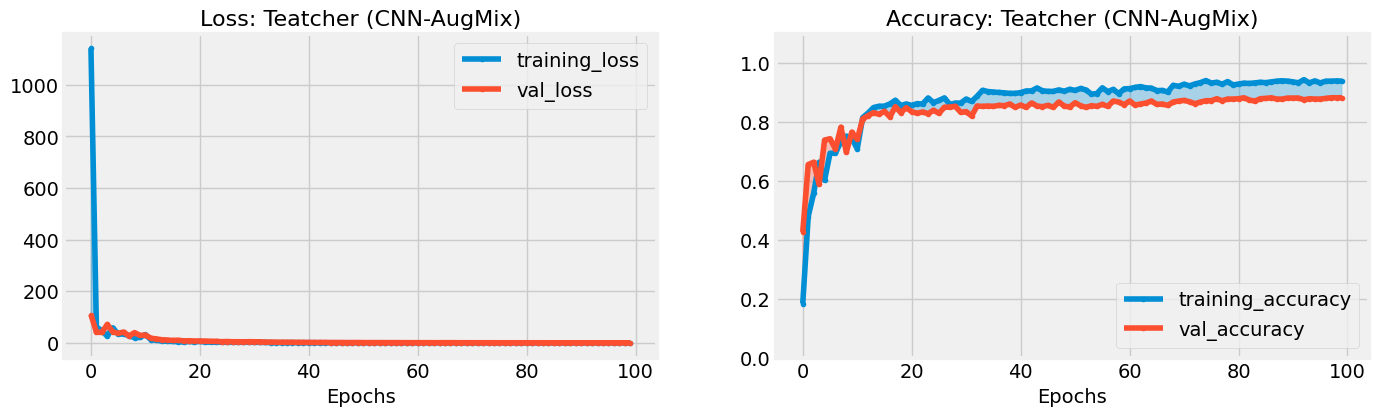

In [ ]:
plot_training_curves(history, 'Teatcher (CNN-AugMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(augmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 74s 614ms/step - accuracy: 0.0892 - top5-acc: 0.3858 - Brier score: 2066099.2500 - auc: 0.5446 - student_loss: 1231.0822 - distillation_loss: 1144.5259 - val_accuracy: 0.1841 - val_top5-acc: 0.3973 - val_Brier score: 24411.6387 - val_auc: 0.5461 - val_student_loss: 166.4286 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 72s 624ms/step - accuracy: 0.1476 - top5-acc: 0.4624 - Brier score: 15317.2949 - auc: 0.5686 - student_loss: 86.5939 - distillation_loss: 497.2406 - val_accuracy: 0.2290 - val_top5-acc: 0.6420 - val_Brier score: 543.1822 - val_auc: 0.6094 - val_student_loss: 16.9351 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 72s 628ms/step - accuracy: 0.2343 - top5-acc: 0.5990 - Brier score: 723.2815 - auc: 0.5541 - student_loss: 12.1700 - distillation_loss: 63.3396 - val_accuracy: 0.3412 - val_top5-acc: 0.7262 - val_Brier score: 235.0129 - val_auc: 0.5820 - val_student_loss: 5.0474 - lr

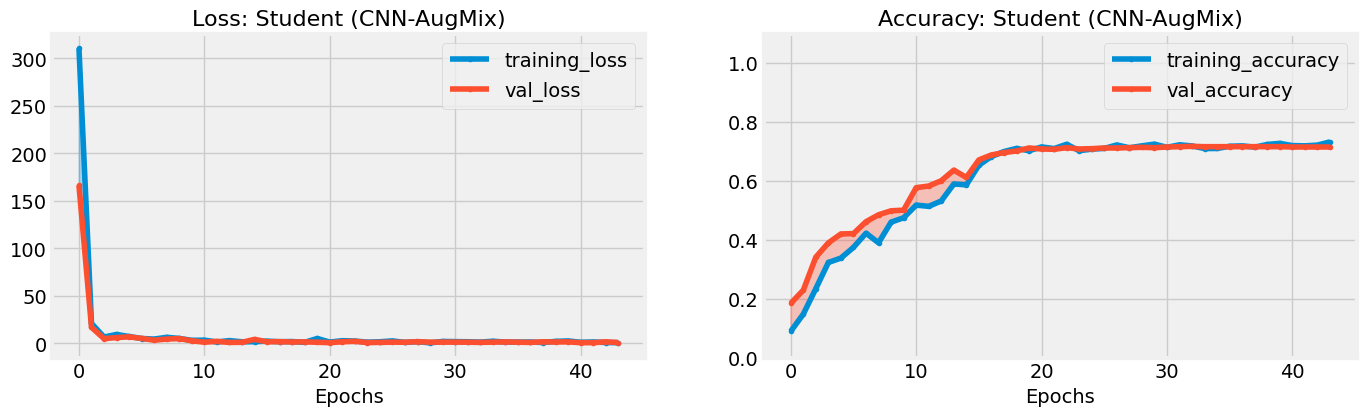

In [ ]:
plot_training_curves(history, 'Student (CNN-AugMix)', model_name='student')

### ▶ CutMix







In [ ]:
history = run_experiment(cutmix_ds, val_ds_v, teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 8s 47ms/step - loss: 663.1039 - accuracy: 0.1279 - top5-acc: 0.4251 - Brier score: 419335.0000 - auc: 0.5300 - val_loss: 277.2216 - val_accuracy: 0.2997 - val_top5-acc: 0.6667 - val_Brier score: 276543.5000 - val_auc: 0.6018 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 7s 45ms/step - loss: 167.2611 - accuracy: 0.3721 - top5-acc: 0.7430 - Brier score: 132801.4531 - auc: 0.6156 - val_loss: 36.7613 - val_accuracy: 0.5589 - val_top5-acc: 0.8923 - val_Brier score: 19769.4941 - val_auc: 0.6305 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 7s 45ms/step - loss: 21.4140 - accuracy: 0.5786 - top5-acc: 0.8799 - Brier score: 7186.3232 - auc: 0.6556 - val_loss: 12.1744 - val_accuracy: 0.6105 - val_top5-acc: 0.9113 - val_Brier score: 2465.9495 - val_auc: 0.7278 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 7s 44ms/step - loss: 12.8060 - accuracy: 0.5988 - top5-acc: 0.9094 - Brier

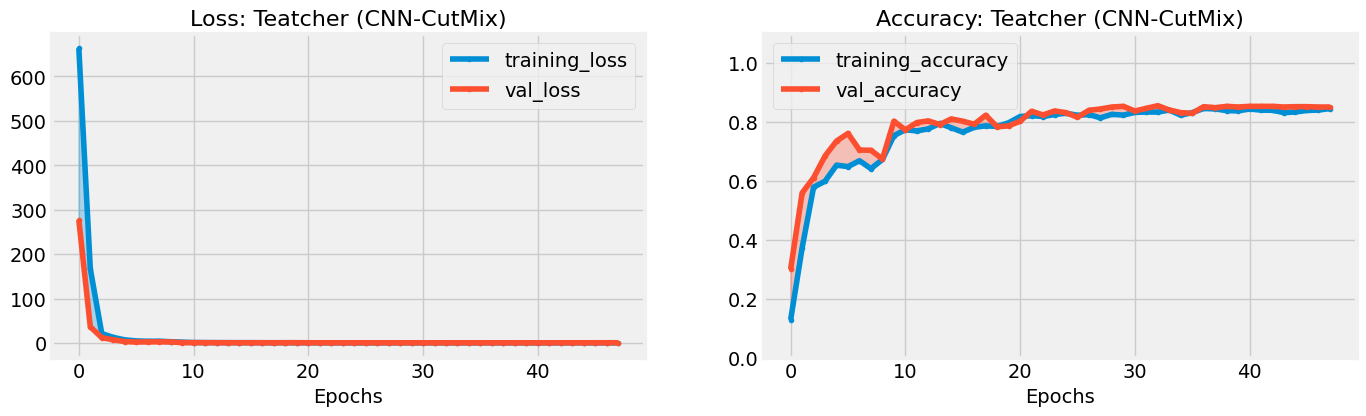

In [ ]:
plot_training_curves(history, 'Teatcher (CNN-CutMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(cutmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 8s 44ms/step - accuracy: 0.3547 - top5-acc: 0.7158 - Brier score: 266.0833 - auc: 0.6024 - student_loss: 6.8847 - distillation_loss: 26.8586 - val_accuracy: 0.3962 - val_top5-acc: 0.7576 - val_Brier score: 51.0746 - val_auc: 0.6833 - val_student_loss: 3.9259 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 7s 43ms/step - accuracy: 0.4327 - top5-acc: 0.7741 - Brier score: 71.8949 - auc: 0.6192 - student_loss: 4.2585 - distillation_loss: 11.3251 - val_accuracy: 0.4388 - val_top5-acc: 0.7856 - val_Brier score: 51.3855 - val_auc: 0.6480 - val_student_loss: 3.7659 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 7s 45ms/step - accuracy: 0.4722 - top5-acc: 0.7943 - Brier score: 57.3437 - auc: 0.6481 - student_loss: 3.7721 - distillation_loss: 9.2553 - val_accuracy: 0.4467 - val_top5-acc: 0.7879 - val_Brier score: 32.9936 - val_auc: 0.7129 - val_student_loss: 3.7851 - lr: 0.0010
Epoch 4/100
112/112 [=

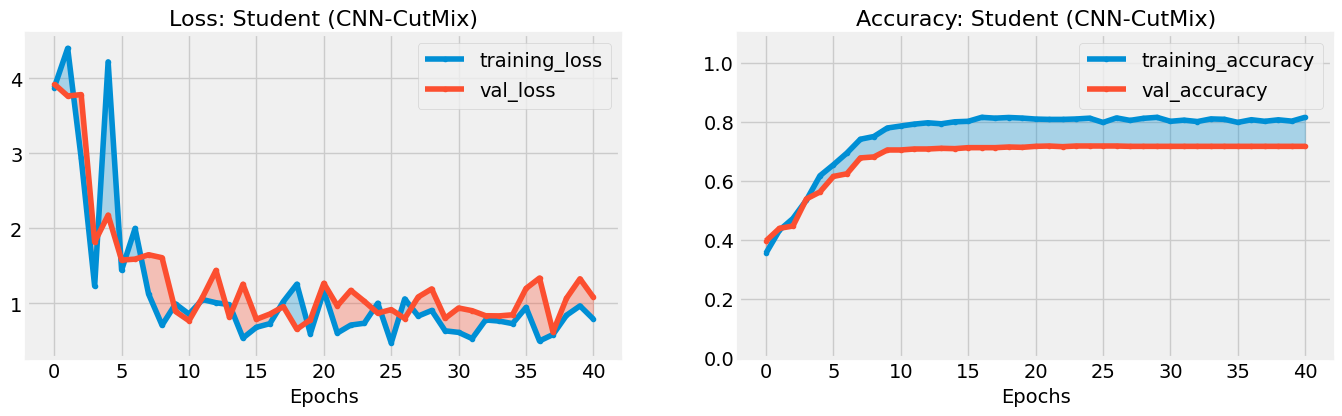

In [ ]:
plot_training_curves(history, 'Student (CNN-CutMix)', model_name='student')

### ▶ MixUp







In [ ]:
history = run_experiment(mixup_ds, val_ds_v, teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 7s 42ms/step - loss: 390.4945 - accuracy: 0.2941 - top5-acc: 0.6462 - Brier score: 335350.0312 - auc: 0.5611 - val_loss: 40.5285 - val_accuracy: 0.6633 - val_top5-acc: 0.9248 - val_Brier score: 57568.9688 - val_auc: 0.6181 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 6s 40ms/step - loss: 21.9858 - accuracy: 0.6891 - top5-acc: 0.9422 - Brier score: 21275.5273 - auc: 0.6196 - val_loss: 13.4954 - val_accuracy: 0.6891 - val_top5-acc: 0.9428 - val_Brier score: 12740.7734 - val_auc: 0.5828 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 7s 40ms/step - loss: 11.0564 - accuracy: 0.7388 - top5-acc: 0.9568 - Brier score: 6786.6816 - auc: 0.6312 - val_loss: 8.9121 - val_accuracy: 0.7138 - val_top5-acc: 0.9203 - val_Brier score: 5341.5293 - val_auc: 0.8570 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 6s 40ms/step - loss: 6.9956 - accuracy: 0.7921 - top5-acc: 0.9711 - Brier score

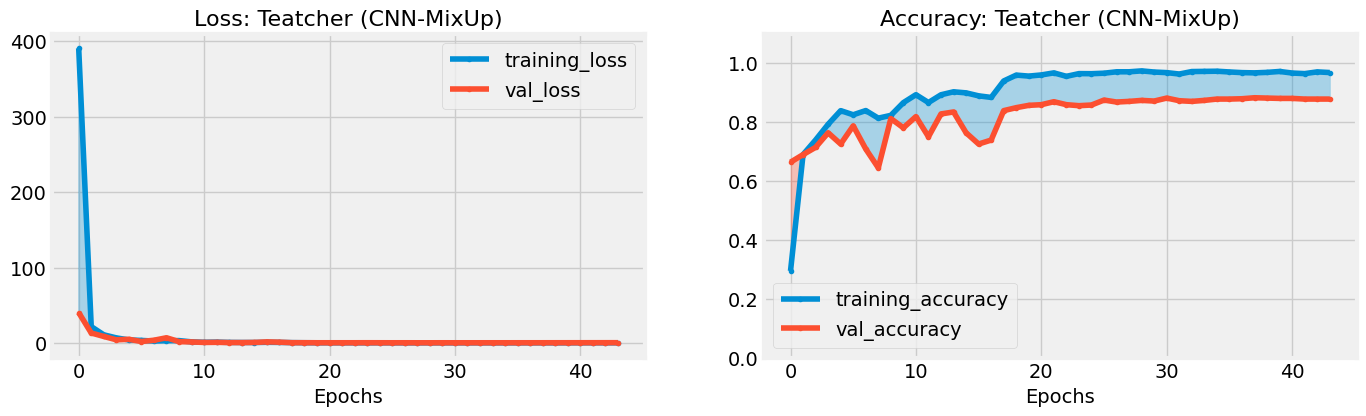

In [ ]:
plot_training_curves(history, 'Teatcher (CNN-MixUp)', model_name='teacher')

In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(mixup_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 6s 27ms/step - accuracy: 0.7573 - top5-acc: 0.9419 - Brier score: 55.8141 - auc: 0.6165 - student_loss: 1.7121 - distillation_loss: 5.5317 - val_accuracy: 0.6274 - val_top5-acc: 0.9169 - val_Brier score: 29.2563 - val_auc: 0.6830 - val_student_loss: 1.2240 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 5s 24ms/step - accuracy: 0.8199 - top5-acc: 0.9652 - Brier score: 36.3553 - auc: 0.6310 - student_loss: 1.1700 - distillation_loss: 2.8448 - val_accuracy: 0.6510 - val_top5-acc: 0.9001 - val_Brier score: 24.4781 - val_auc: 0.7072 - val_student_loss: 1.6048 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 5s 25ms/step - accuracy: 0.8044 - top5-acc: 0.9515 - Brier score: 35.9321 - auc: 0.6300 - student_loss: 1.3924 - distillation_loss: 3.4798 - val_accuracy: 0.6229 - val_top5-acc: 0.8889 - val_Brier score: 20.1107 - val_auc: 0.7173 - val_student_loss: 0.9972 - lr: 0.0010
Epoch 4/100
112/112 [====

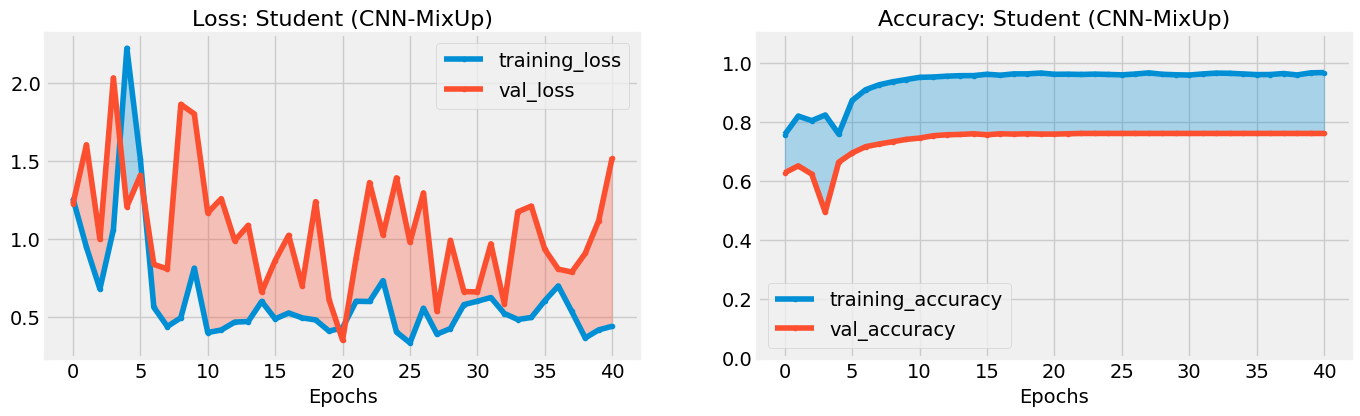

In [ ]:
plot_training_curves(history, 'Student (CNN-MixUp)', model_name='student')

### ▶ AugPip







In [ ]:
history = run_experiment(augpip_ds, val_ds_v, teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 78s 671ms/step - loss: 1200.2228 - accuracy: 0.0766 - top5-acc: 0.3662 - Brier score: 1188624.6250 - auc: 0.5070 - val_loss: 524.5498 - val_accuracy: 0.0774 - val_top5-acc: 0.3591 - val_Brier score: 246721.1250 - val_auc: 0.5104 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 77s 673ms/step - loss: 300.7193 - accuracy: 0.1880 - top5-acc: 0.5376 - Brier score: 191173.9688 - auc: 0.5392 - val_loss: 50.3171 - val_accuracy: 0.4343 - val_top5-acc: 0.8182 - val_Brier score: 13419.6699 - val_auc: 0.7524 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 78s 677ms/step - loss: 38.2459 - accuracy: 0.3712 - top5-acc: 0.7601 - Brier score: 11300.0889 - auc: 0.5880 - val_loss: 6.1415 - val_accuracy: 0.6712 - val_top5-acc: 0.9203 - val_Brier score: 3185.3545 - val_auc: 0.5538 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 78s 676ms/step - loss: 14.6390 - accuracy: 0.4035 - top5-acc: 0.76

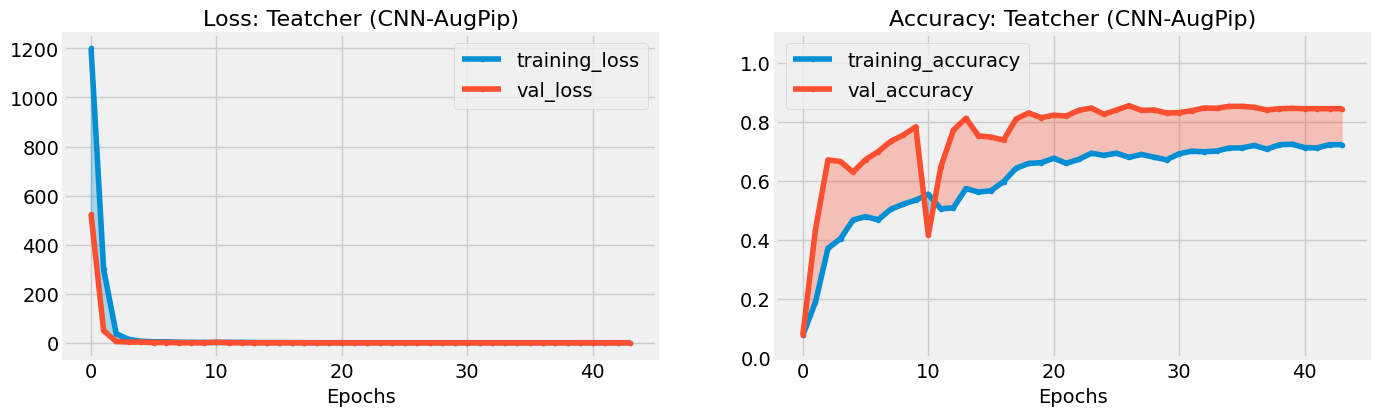

In [ ]:
plot_training_curves(history, 'Teatcher (CNN-AugPip)', model_name='teacher')

In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(augpip_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 78s 668ms/step - accuracy: 0.3979 - top5-acc: 0.7590 - Brier score: 46.3491 - auc: 0.6337 - student_loss: 3.8807 - distillation_loss: 10.1549 - val_accuracy: 0.7003 - val_top5-acc: 0.9304 - val_Brier score: 6.8054 - val_auc: 0.7950 - val_student_loss: 0.8471 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 77s 670ms/step - accuracy: 0.5867 - top5-acc: 0.8808 - Brier score: 7.5254 - auc: 0.6818 - student_loss: 1.6971 - distillation_loss: 1.2926 - val_accuracy: 0.7273 - val_top5-acc: 0.9383 - val_Brier score: 8.0399 - val_auc: 0.7832 - val_student_loss: 1.2483 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 77s 670ms/step - accuracy: 0.6285 - top5-acc: 0.9029 - Brier score: 7.9513 - auc: 0.6820 - student_loss: 1.5349 - distillation_loss: 1.0352 - val_accuracy: 0.7262 - val_top5-acc: 0.9304 - val_Brier score: 6.1273 - val_auc: 0.8129 - val_student_loss: 1.6053 - lr: 0.0010
Epoch 4/100
112/112 [==

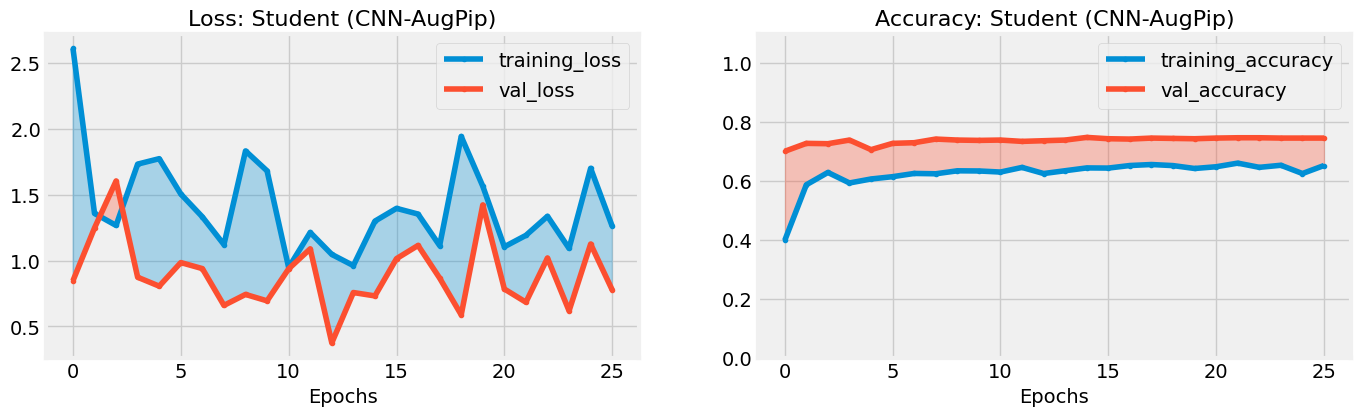

In [ ]:
plot_training_curves(history, 'Student (CNN-AugPip)', model_name='student')



---

##⏰ Flush

In [ ]:
del history



---



# 🔴 Transformer (neighborhood attention)



In [ ]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256
# AUGMENTATION
PATCH_SIZE = 6
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMG_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [ ]:
def create_transfomer(vanilla=False):
    inputs = layers.Input(shape=input_shape)

    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model



---



In [ ]:
#vanilla=False ====> transformer with self locality attention (neighborhood)
TRANSFORMER_LAYERS = 8
NUM_HEADS = 4
transformer_teacher = create_transfomer(vanilla=False)
#####################################################
TRANSFORMER_LAYERS = 4
NUM_HEADS = 2
transformer_student = create_transfomer(vanilla=False)

### ▶ AugMix







In [ ]:
history = run_experiment(augmix_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 89s 673ms/step - loss: 8.0971 - accuracy: 0.1883 - top5-acc: 0.5441 - Brier score: 52.4341 - auc: 0.6242 - val_loss: 2.2056 - val_accuracy: 0.3345 - val_top5-acc: 0.6981 - val_Brier score: 5.8477 - val_auc: 0.7309 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 76s 664ms/step - loss: 2.5950 - accuracy: 0.2910 - top5-acc: 0.6799 - Brier score: 14.3370 - auc: 0.7049 - val_loss: 1.7524 - val_accuracy: 0.4141 - val_top5-acc: 0.7710 - val_Brier score: 3.2965 - val_auc: 0.7830 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 76s 662ms/step - loss: 1.9235 - accuracy: 0.3575 - top5-acc: 0.7419 - Brier score: 12.8545 - auc: 0.7392 - val_loss: 1.6599 - val_accuracy: 0.4747 - val_top5-acc: 0.7957 - val_Brier score: 4.6426 - val_auc: 0.8134 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 76s 665ms/step - loss: 1.8984 - accuracy: 0.3889 - top5-acc: 0.7573 - Brier score: 15.4163 - auc: 0

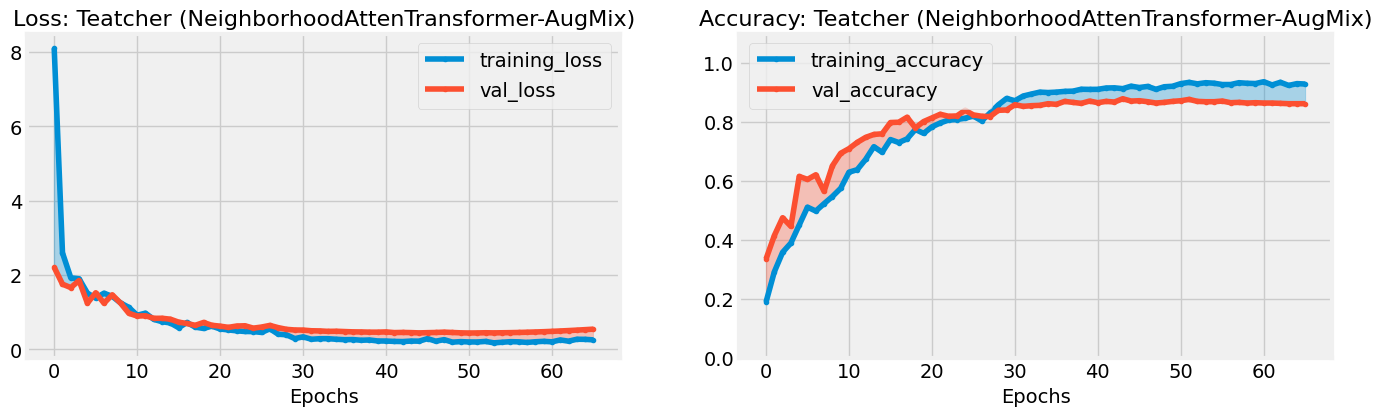

In [ ]:
plot_training_curves(history, 'Teatcher (NeighborhoodAttenTransformer-AugMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(augmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 88s 613ms/step - accuracy: 0.2680 - top5-acc: 0.6299 - Brier score: 24.4251 - auc: 0.6709 - student_loss: 4.4592 - distillation_loss: 21.4919 - val_accuracy: 0.4916 - val_top5-acc: 0.8249 - val_Brier score: 12.4460 - val_auc: 0.8129 - val_student_loss: 2.2701 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 75s 648ms/step - accuracy: 0.4139 - top5-acc: 0.7643 - Brier score: 20.6834 - auc: 0.7483 - student_loss: 2.3674 - distillation_loss: 13.1135 - val_accuracy: 0.5578 - val_top5-acc: 0.8653 - val_Brier score: 9.7875 - val_auc: 0.8399 - val_student_loss: 0.8839 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 75s 654ms/step - accuracy: 0.4865 - top5-acc: 0.8148 - Brier score: 22.5245 - auc: 0.7756 - student_loss: 1.8939 - distillation_loss: 11.5734 - val_accuracy: 0.5847 - val_top5-acc: 0.8541 - val_Brier score: 10.6622 - val_auc: 0.8357 - val_student_loss: 1.5839 - lr: 0.0010
Epoch 4/100
112/1

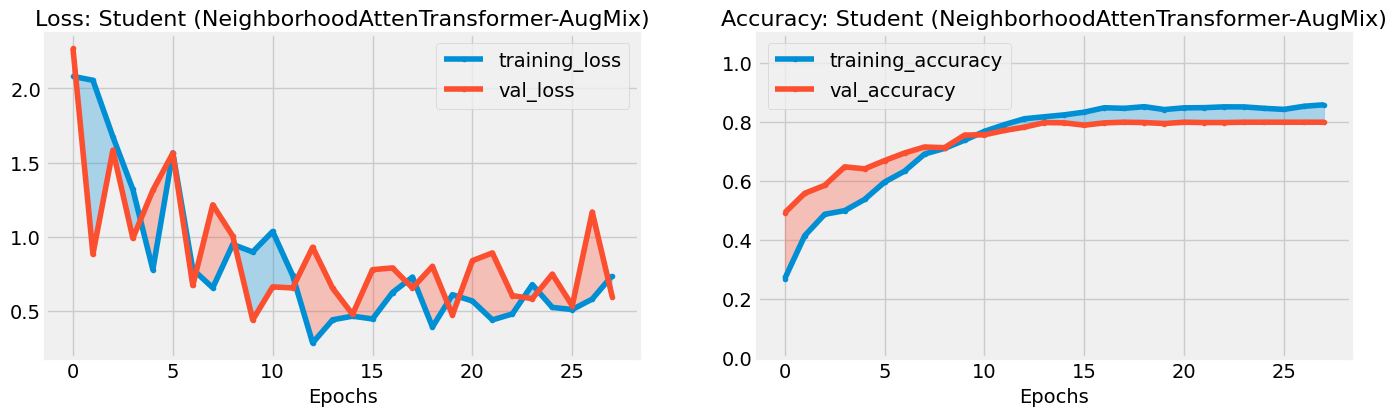

In [ ]:
plot_training_curves(history, 'Student (NeighborhoodAttenTransformer-AugMix)', model_name='student')

### ▶ CutMix







In [ ]:
history = run_experiment(cutmix_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 360s 945ms/step - loss: 7.5637 - accuracy: 0.1448 - top5-acc: 0.4938 - Brier score: 36.9963 - auc: 0.5841 - val_loss: 2.2323 - val_accuracy: 0.3030 - val_top5-acc: 0.6510 - val_Brier score: 2.4063 - val_auc: 0.7107 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 42s 356ms/step - loss: 2.9923 - accuracy: 0.1995 - top5-acc: 0.5693 - Brier score: 8.9553 - auc: 0.6352 - val_loss: 2.0832 - val_accuracy: 0.3468 - val_top5-acc: 0.7598 - val_Brier score: 1.5669 - val_auc: 0.7656 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 42s 356ms/step - loss: 2.4082 - accuracy: 0.2621 - top5-acc: 0.6613 - Brier score: 7.8108 - auc: 0.6766 - val_loss: 1.9820 - val_accuracy: 0.4119 - val_top5-acc: 0.7688 - val_Brier score: 3.1611 - val_auc: 0.7847 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 41s 352ms/step - loss: 2.3619 - accuracy: 0.2795 - top5-acc: 0.6526 - Brier score: 7.6576 - auc: 0.6

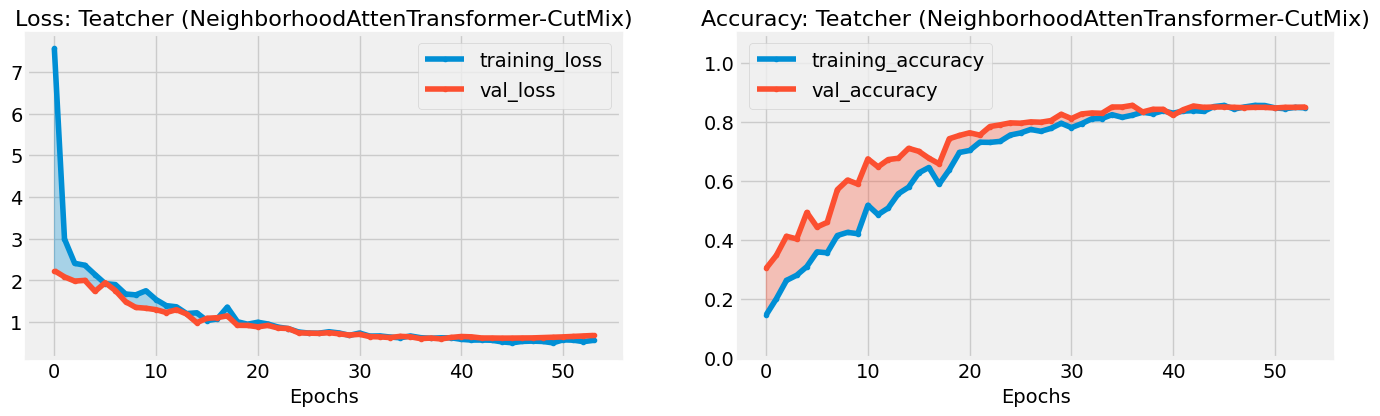

In [ ]:
plot_training_curves(history, 'Teatcher (NeighborhoodAttenTransformer-CutMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(cutmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 46s 244ms/step - accuracy: 0.1709 - top5-acc: 0.5553 - Brier score: 11.0831 - auc: 0.6303 - student_loss: 3.6740 - distillation_loss: 6.7241 - val_accuracy: 0.3490 - val_top5-acc: 0.7475 - val_Brier score: 0.3349 - val_auc: 0.7653 - val_student_loss: 2.0994 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 27s 226ms/step - accuracy: 0.2556 - top5-acc: 0.6813 - Brier score: 2.4531 - auc: 0.7000 - student_loss: 2.3564 - distillation_loss: 3.0172 - val_accuracy: 0.4063 - val_top5-acc: 0.8148 - val_Brier score: 0.4134 - val_auc: 0.8064 - val_student_loss: 2.1129 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 26s 218ms/step - accuracy: 0.3095 - top5-acc: 0.7250 - Brier score: 2.4609 - auc: 0.7162 - student_loss: 2.2040 - distillation_loss: 2.7845 - val_accuracy: 0.4388 - val_top5-acc: 0.8215 - val_Brier score: 0.8560 - val_auc: 0.8192 - val_student_loss: 1.9238 - lr: 0.0010
Epoch 4/100
112/112 [===

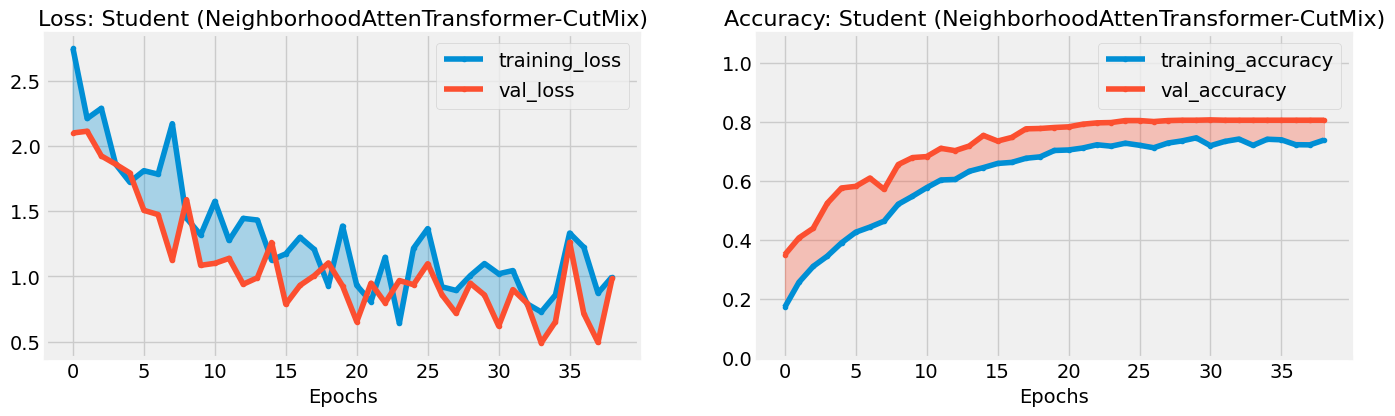

In [ ]:
plot_training_curves(history, 'Student (NeighborhoodAttenTransformer-CutMix)', model_name='student')

### ▶ MixUp







In [ ]:
history = run_experiment(mixup_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 54s 374ms/step - loss: 7.7529 - accuracy: 0.1807 - top5-acc: 0.5494 - Brier score: 42.7477 - auc: 0.5976 - val_loss: 2.2837 - val_accuracy: 0.2705 - val_top5-acc: 0.6319 - val_Brier score: 1.2840 - val_auc: 0.7172 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 42s 356ms/step - loss: 2.8775 - accuracy: 0.2466 - top5-acc: 0.6285 - Brier score: 9.3499 - auc: 0.6294 - val_loss: 2.2458 - val_accuracy: 0.3008 - val_top5-acc: 0.6510 - val_Brier score: 0.7219 - val_auc: 0.7155 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 42s 357ms/step - loss: 2.6387 - accuracy: 0.2640 - top5-acc: 0.6594 - Brier score: 7.7426 - auc: 0.6502 - val_loss: 2.1941 - val_accuracy: 0.2985 - val_top5-acc: 0.7183 - val_Brier score: 1.3322 - val_auc: 0.7486 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 42s 357ms/step - loss: 2.5362 - accuracy: 0.2682 - top5-acc: 0.6535 - Brier score: 7.0269 - auc: 0.65

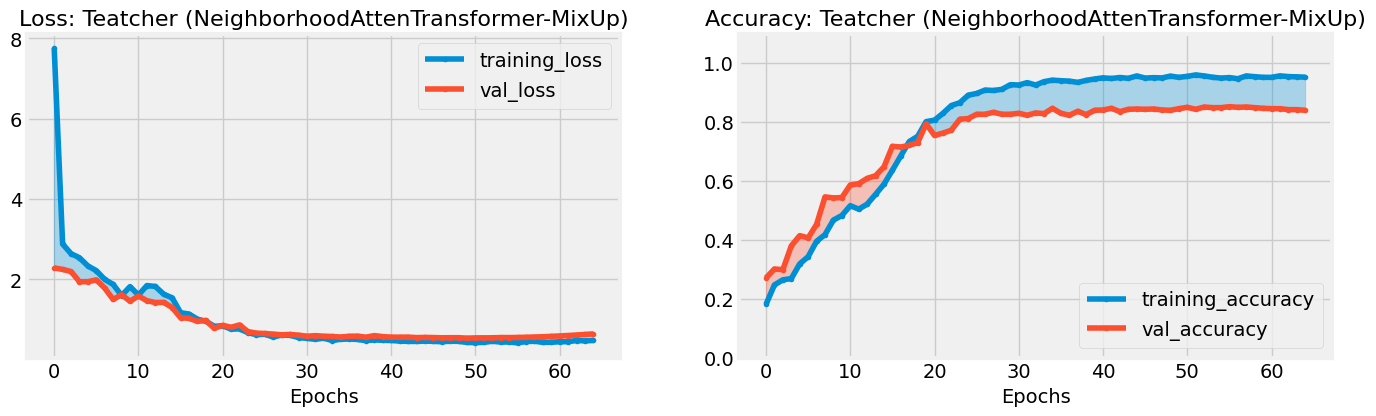

In [ ]:
plot_training_curves(history, 'Teatcher (NeighborhoodAttenTransformer-MixUp)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(mixup_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 46s 242ms/step - accuracy: 0.1958 - top5-acc: 0.5957 - Brier score: 13.1667 - auc: 0.6399 - student_loss: 3.7916 - distillation_loss: 6.3477 - val_accuracy: 0.3311 - val_top5-acc: 0.7363 - val_Brier score: 0.5676 - val_auc: 0.7758 - val_student_loss: 2.0273 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 27s 227ms/step - accuracy: 0.2842 - top5-acc: 0.7012 - Brier score: 2.6146 - auc: 0.6930 - student_loss: 2.3427 - distillation_loss: 2.3094 - val_accuracy: 0.3838 - val_top5-acc: 0.7598 - val_Brier score: 0.6139 - val_auc: 0.7831 - val_student_loss: 2.2671 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 27s 227ms/step - accuracy: 0.3622 - top5-acc: 0.7514 - Brier score: 2.3820 - auc: 0.7207 - student_loss: 2.1155 - distillation_loss: 2.0025 - val_accuracy: 0.4792 - val_top5-acc: 0.7991 - val_Brier score: 0.6817 - val_auc: 0.8101 - val_student_loss: 1.9226 - lr: 0.0010
Epoch 4/100
112/112 [===

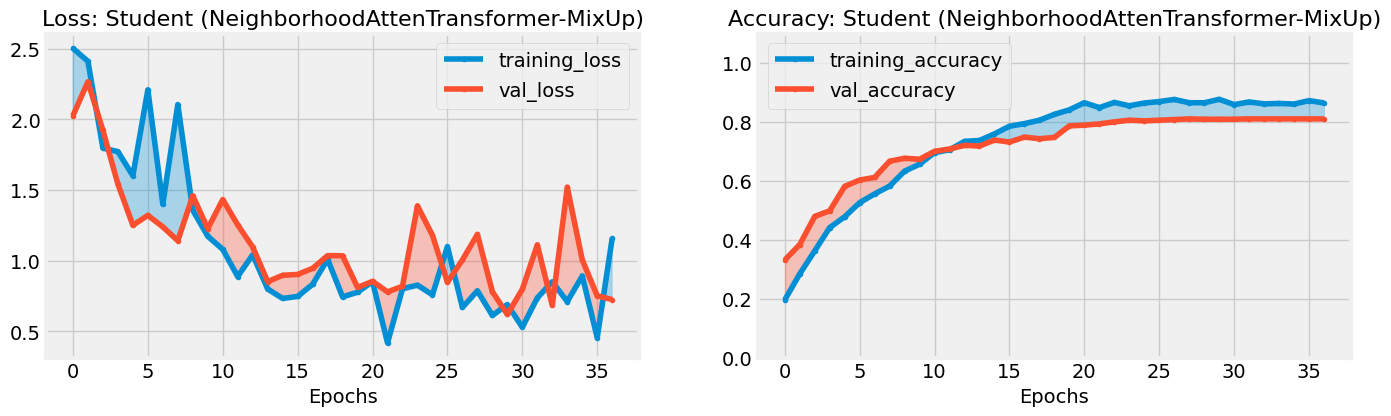

In [ ]:
plot_training_curves(history, 'Student (NeighborhoodAttenTransformer-MixUp)', model_name='student')

In [ ]:
del history

### ▶ AugPip







In [ ]:
history = run_experiment(augpip_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 381s 1s/step - loss: 6.9869 - accuracy: 0.1105 - top5-acc: 0.4450 - Brier score: 31.2268 - auc: 0.5559 - val_loss: 2.6864 - val_accuracy: 0.1425 - val_top5-acc: 0.4355 - val_Brier score: 0.7465 - val_auc: 0.5856 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 81s 698ms/step - loss: 2.7989 - accuracy: 0.1156 - top5-acc: 0.4487 - Brier score: 1.4716 - auc: 0.5547 - val_loss: 2.4833 - val_accuracy: 0.1740 - val_top5-acc: 0.5870 - val_Brier score: 0.3951 - val_auc: 0.6674 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 80s 697ms/step - loss: 2.7426 - accuracy: 0.1041 - top5-acc: 0.4327 - Brier score: 0.8165 - auc: 0.5470 - val_loss: 2.5594 - val_accuracy: 0.1785 - val_top5-acc: 0.5623 - val_Brier score: 0.2514 - val_auc: 0.6303 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 80s 698ms/step - loss: 2.5785 - accuracy: 0.1369 - top5-acc: 0.4820 - Brier score: 1.0742 - auc: 0.5754

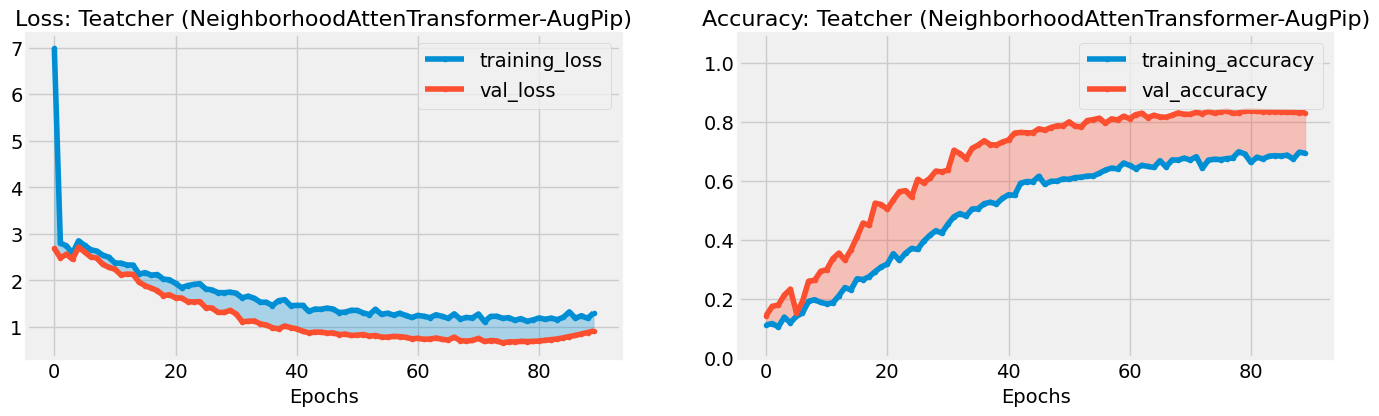

In [ ]:
plot_training_curves(history, 'Teatcher (NeighborhoodAttenTransformer-AugPip)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(augpip_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 92s 645ms/step - accuracy: 0.1602 - top5-acc: 0.5334 - Brier score: 7.4592 - auc: 0.6169 - student_loss: 3.4934 - distillation_loss: 3.9490 - val_accuracy: 0.2649 - val_top5-acc: 0.7295 - val_Brier score: 0.2639 - val_auc: 0.7535 - val_student_loss: 2.3820 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 79s 688ms/step - accuracy: 0.2104 - top5-acc: 0.6487 - Brier score: 1.1968 - auc: 0.6722 - student_loss: 2.4140 - distillation_loss: 1.1667 - val_accuracy: 0.3816 - val_top5-acc: 0.7778 - val_Brier score: 0.5422 - val_auc: 0.7905 - val_student_loss: 2.1470 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 78s 675ms/step - accuracy: 0.2514 - top5-acc: 0.6942 - Brier score: 1.2244 - auc: 0.6910 - student_loss: 2.3128 - distillation_loss: 1.0519 - val_accuracy: 0.3872 - val_top5-acc: 0.8002 - val_Brier score: 0.4020 - val_auc: 0.8085 - val_student_loss: 2.1792 - lr: 0.0010
Epoch 4/100
112/112 [====

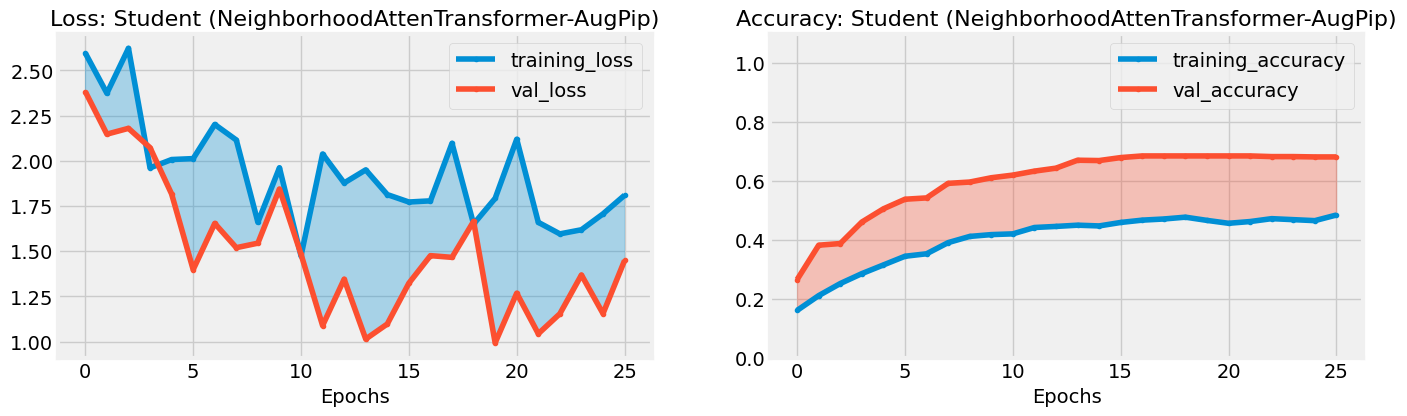

In [ ]:
plot_training_curves(history, 'Student (NeighborhoodAttenTransformer-AugPip)', model_name='student')



---

##⏰ Flush

In [ ]:
del history
del transformer_student
del transformer_teacher



---



# 📂 Load BTDS-17C

In [ ]:
##################
NUM_CLASSES = 17
##################
path = '/content/drive/MyDrive/Multiclass_Brain_Tumor_MRI/MRI_17Classes/'
# train data
train_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 4415 files belonging to 17 classes.
Using 3532 files for training.
Found 4415 files belonging to 17 classes.
Using 883 files for validation.


## ◼ Class Weighting

In [ ]:
#label_mode='categorical',
train_ds_cat = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
)
class_names = train_ds_cat.class_names
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(NUM_CLASSES): classes.append(i)
class_weights=compute_class_weight(class_weight="balanced",classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

Found 4415 files belonging to 17 classes.


{0: 0.5700371651928745,
 1: 0.5110294117647058,
 2: 0.7562053723223393,
 3: 0.7583972719522591,
 4: 0.41863529411764705,
 5: 0.7952798140532809,
 6: 0.9619377162629758,
 7: 0.8991307863351526,
 8: 1.5482074486599373,
 9: 1.0024791525805725,
 10: 2.3361344537815127,
 11: 1.721362229102167,
 12: 5.450980392156863,
 13: 4.590299277605779,
 14: 1.7101114955786236,
 15: 1.348696179502729,
 16: 2.127211860353898}

# 🅰 Data augmentation

In the original paper, the authors use AutoAugment to induce stronger regularization. For this example, we will be using the standard geometric augmentations like random cropping and flipping. https://arxiv.org/abs/1805.09501

In [ ]:
def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, NUM_CLASSES)
    return {"images": image, "labels": label}

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

augmix = keras_cv.layers.AugMix([0, 255])
mixup = keras_cv.layers.MixUp()
cutmix = keras_cv.layers.CutMix(alpha=0.02)

#No augmentation
train_ds_v = train_ds.map(to_dict)
train_ds_v = train_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
train_ds_v = train_ds_v.prefetch(AUTOTUNE)
val_ds_v = val_ds.map(to_dict)
val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
val_ds_v = val_ds_v.prefetch(AUTOTUNE) #Use this for fit

In [ ]:
def aug_pipeline1(samples):
    samples = augmix(samples, training=True)
    return samples
def aug_pipeline2(samples):
    samples = mixup(samples, training=True)
    return samples
def aug_pipeline3(samples):
    samples = cutmix(samples, training=True)
    return samples
def aug_pipeline(samples):
    samples = augmix(samples, training=True)
    samples = mixup(samples, training=True)
    samples = cutmix(samples, training=True)
    return samples
#AugMix
augmix_ds = train_ds.shuffle(1000).map(to_dict)
augmix_ds = augmix_ds.map(aug_pipeline1)
augmix_ds = augmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
augmix_ds = augmix_ds.prefetch(AUTOTUNE) #Use this for fit
#MixUp
mixup_ds = train_ds.shuffle(1000).map(to_dict)
mixup_ds = mixup_ds.map(aug_pipeline2)
mixup_ds = mixup_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
mixup_ds = mixup_ds.prefetch(AUTOTUNE) #Use this for fit
#CutMix
cutmix_ds = train_ds.shuffle(1000).map(to_dict)
cutmix_ds = cutmix_ds.map(aug_pipeline3)
cutmix_ds = cutmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
cutmix_ds = cutmix_ds.prefetch(AUTOTUNE) #Use this for fit
#AugPip
augpip_ds = train_ds.shuffle(1000).map(to_dict)
augpip_ds = augpip_ds.map(aug_pipeline)
augpip_ds = augpip_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
augpip_ds = augpip_ds.prefetch(AUTOTUNE) #Use this for fit

## ◼ CNN

In [ ]:
# Create the teacher
teacher = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(NUM_CLASSES),
    ],
    name="teacher",
)
# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(NUM_CLASSES),
    ],
    name="student",
)

### ▶ AugMix







In [ ]:
history = run_experiment(augmix_ds, val_ds_v, teacher, model_name='teacher')

Epoch 1/100
111/111 [==============================] - 303s 949ms/step - loss: 1701.7217 - accuracy: 0.1328 - top5-acc: 0.4196 - Brier score: 10983131.0000 - auc: 0.5574 - val_loss: 132.6794 - val_accuracy: 0.3364 - val_top5-acc: 0.6455 - val_Brier score: 37446.5156 - val_auc: 0.6538 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 72s 629ms/step - loss: 85.9784 - accuracy: 0.4080 - top5-acc: 0.7500 - Brier score: 37355.6562 - auc: 0.6808 - val_loss: 87.8754 - val_accuracy: 0.4281 - val_top5-acc: 0.7067 - val_Brier score: 45788.4609 - val_auc: 0.6054 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 72s 627ms/step - loss: 66.9493 - accuracy: 0.4785 - top5-acc: 0.7913 - Brier score: 31895.7207 - auc: 0.6846 - val_loss: 46.9219 - val_accuracy: 0.5889 - val_top5-acc: 0.8652 - val_Brier score: 33157.9688 - val_auc: 0.6763 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 72s 626ms/step - loss: 213.3818 - accuracy: 0.4703 - top5-acc: 0.

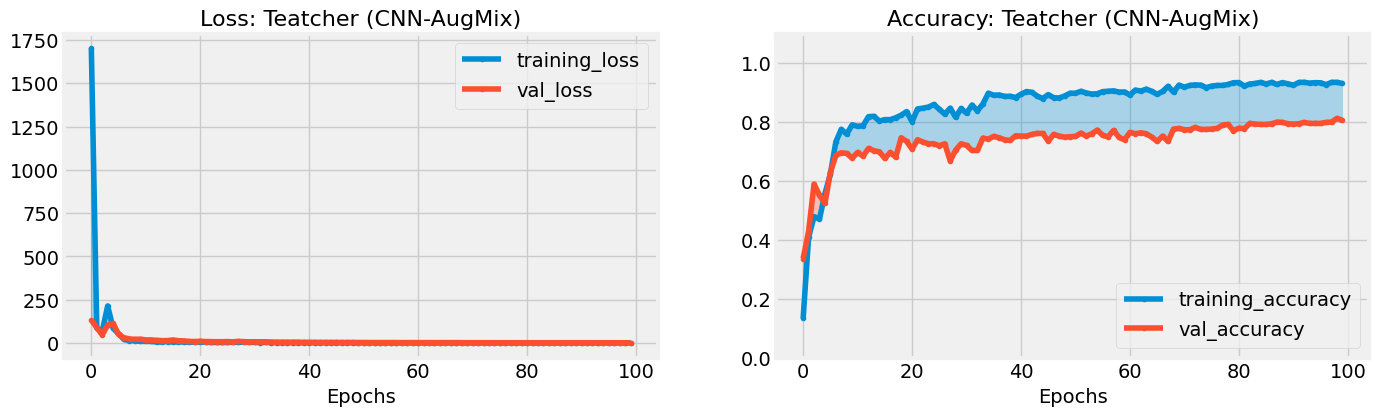

In [ ]:
plot_training_curves(history, 'Teatcher (CNN-AugMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(augmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
111/111 [==============================] - 73s 611ms/step - accuracy: 0.1082 - top5-acc: 0.3817 - Brier score: 80083.1328 - auc: 0.5236 - student_loss: 169.9594 - distillation_loss: 548.0746 - val_accuracy: 0.1653 - val_top5-acc: 0.5130 - val_Brier score: 1608.2423 - val_auc: 0.5270 - val_student_loss: 25.6684 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 71s 623ms/step - accuracy: 0.1900 - top5-acc: 0.5235 - Brier score: 1269.7642 - auc: 0.5309 - student_loss: 17.7501 - distillation_loss: 98.3384 - val_accuracy: 0.1812 - val_top5-acc: 0.5243 - val_Brier score: 714.2313 - val_auc: 0.5355 - val_student_loss: 22.2683 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 71s 625ms/step - accuracy: 0.2370 - top5-acc: 0.5651 - Brier score: 1008.2565 - auc: 0.5255 - student_loss: 13.3791 - distillation_loss: 65.1796 - val_accuracy: 0.2344 - val_top5-acc: 0.5980 - val_Brier score: 561.9635 - val_auc: 0.5361 - val_student_loss: 9.9598 - lr: 0.001

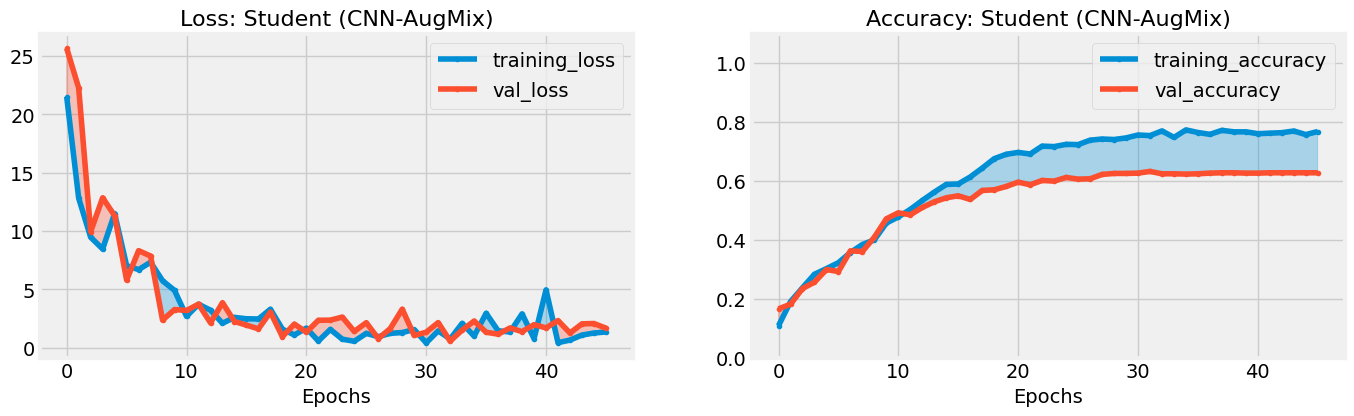

In [ ]:
plot_training_curves(history, 'Student (CNN-AugMix)', model_name='student')

### ▶ CutMix







In [ ]:
history = run_experiment(cutmix_ds, val_ds_v, teacher, model_name='teacher')

Epoch 1/100
111/111 [==============================] - 338s 593ms/step - loss: 920.7468 - accuracy: 0.1642 - top5-acc: 0.4941 - Brier score: 2284945.0000 - auc: 0.5734 - val_loss: 120.6067 - val_accuracy: 0.3715 - val_top5-acc: 0.7384 - val_Brier score: 87273.4766 - val_auc: 0.6393 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 7s 44ms/step - loss: 85.7202 - accuracy: 0.3978 - top5-acc: 0.7347 - Brier score: 30336.7422 - auc: 0.6659 - val_loss: 65.1458 - val_accuracy: 0.4587 - val_top5-acc: 0.7384 - val_Brier score: 21745.3105 - val_auc: 0.6723 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 7s 45ms/step - loss: 68.7424 - accuracy: 0.4632 - top5-acc: 0.7896 - Brier score: 34604.1055 - auc: 0.6620 - val_loss: 31.1119 - val_accuracy: 0.5176 - val_top5-acc: 0.8335 - val_Brier score: 11264.2354 - val_auc: 0.6987 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 7s 45ms/step - loss: 37.6508 - accuracy: 0.5713 - top5-acc: 0.8669 - Br

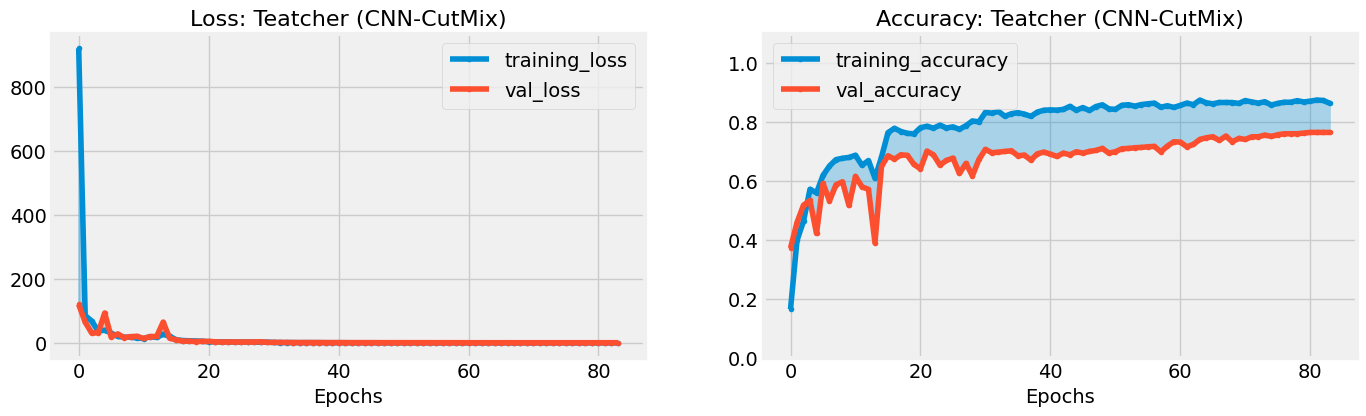

In [ ]:
plot_training_curves(history, 'Teatcher (CNN-CutMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(cutmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
111/111 [==============================] - 10s 43ms/step - accuracy: 0.0784 - top5-acc: 0.3089 - Brier score: 927470.4375 - auc: 0.5044 - student_loss: 765.2743 - distillation_loss: 1006.5038 - val_accuracy: 0.1393 - val_top5-acc: 0.4349 - val_Brier score: 7381.5210 - val_auc: 0.5430 - val_student_loss: 68.7990 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 7s 44ms/step - accuracy: 0.1232 - top5-acc: 0.4012 - Brier score: 4286.9897 - auc: 0.5382 - student_loss: 42.2039 - distillation_loss: 252.1489 - val_accuracy: 0.1461 - val_top5-acc: 0.4677 - val_Brier score: 738.1029 - val_auc: 0.5476 - val_student_loss: 13.0678 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 7s 44ms/step - accuracy: 0.2027 - top5-acc: 0.5130 - Brier score: 367.1250 - auc: 0.5414 - student_loss: 12.5578 - distillation_loss: 51.9220 - val_accuracy: 0.2378 - val_top5-acc: 0.5968 - val_Brier score: 160.2709 - val_auc: 0.5532 - val_student_loss: 5.5220 - lr: 0.0010
E

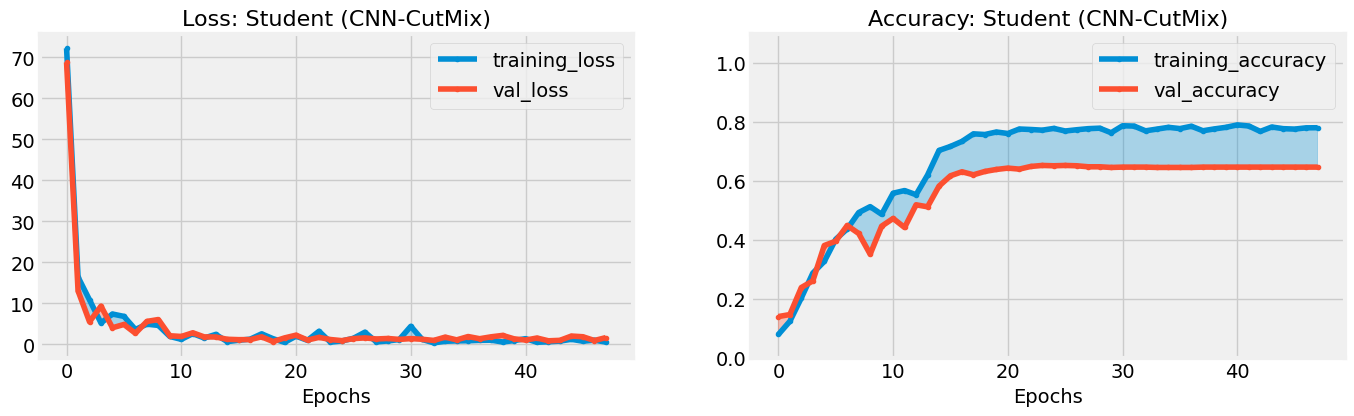

In [ ]:
plot_training_curves(history, 'Student (CNN-CutMix)', model_name='student')

### ▶ MixUp







In [ ]:
history = run_experiment(mixup_ds, val_ds_v, teacher, model_name='teacher')

Epoch 1/100
111/111 [==============================] - 331s 699ms/step - loss: 1366.4958 - accuracy: 0.1801 - top5-acc: 0.4830 - Brier score: 3910734.7500 - auc: 0.5564 - val_loss: 173.4831 - val_accuracy: 0.4043 - val_top5-acc: 0.6636 - val_Brier score: 65917.7734 - val_auc: 0.6214 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 14s 98ms/step - loss: 70.6451 - accuracy: 0.5085 - top5-acc: 0.8055 - Brier score: 27472.7559 - auc: 0.6363 - val_loss: 50.2700 - val_accuracy: 0.5311 - val_top5-acc: 0.7792 - val_Brier score: 19464.1875 - val_auc: 0.7053 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 14s 98ms/step - loss: 43.5680 - accuracy: 0.6274 - top5-acc: 0.8817 - Brier score: 19856.6680 - auc: 0.6491 - val_loss: 53.9022 - val_accuracy: 0.5391 - val_top5-acc: 0.8097 - val_Brier score: 21600.6113 - val_auc: 0.7243 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 14s 99ms/step - loss: 25.6541 - accuracy: 0.7384 - top5-acc: 0.9233 

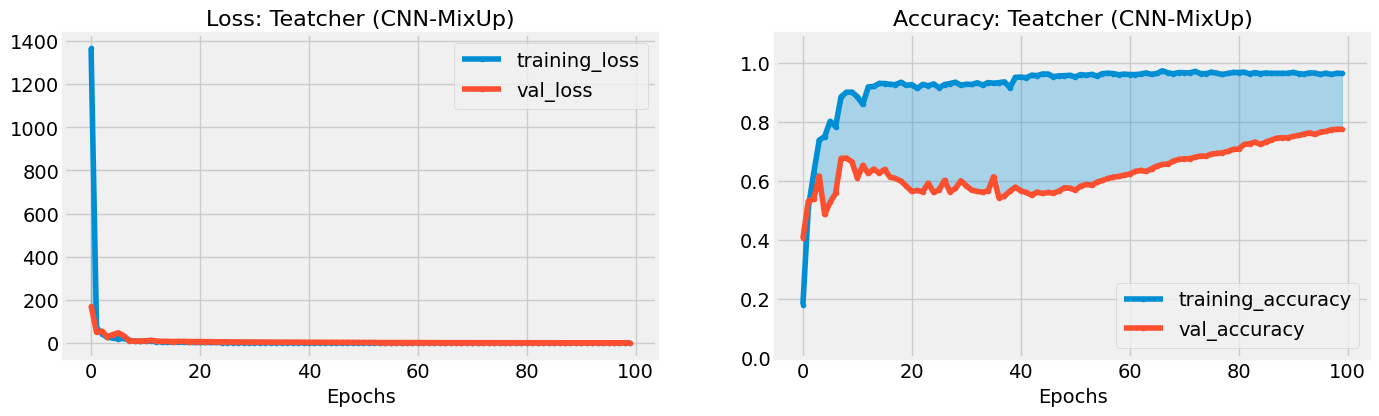

In [ ]:
plot_training_curves(history, 'Teatcher (CNN-MixUp)', model_name='teacher')

In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(mixup_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
111/111 [==============================] - 11s 49ms/step - accuracy: 0.0923 - top5-acc: 0.3398 - Brier score: 154449.0938 - auc: 0.5155 - student_loss: 305.0918 - distillation_loss: 895.2372 - val_accuracy: 0.0759 - val_top5-acc: 0.4122 - val_Brier score: 2322.5332 - val_auc: 0.5521 - val_student_loss: 48.5719 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 8s 46ms/step - accuracy: 0.1237 - top5-acc: 0.4108 - Brier score: 2345.7639 - auc: 0.5253 - student_loss: 37.1748 - distillation_loss: 236.7267 - val_accuracy: 0.1733 - val_top5-acc: 0.4904 - val_Brier score: 649.4427 - val_auc: 0.5415 - val_student_loss: 17.7598 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 8s 46ms/step - accuracy: 0.1968 - top5-acc: 0.5147 - Brier score: 647.7508 - auc: 0.5179 - student_loss: 14.7516 - distillation_loss: 63.5045 - val_accuracy: 0.1959 - val_top5-acc: 0.5402 - val_Brier score: 496.4814 - val_auc: 0.5190 - val_student_loss: 10.4409 - lr: 0.0010
E

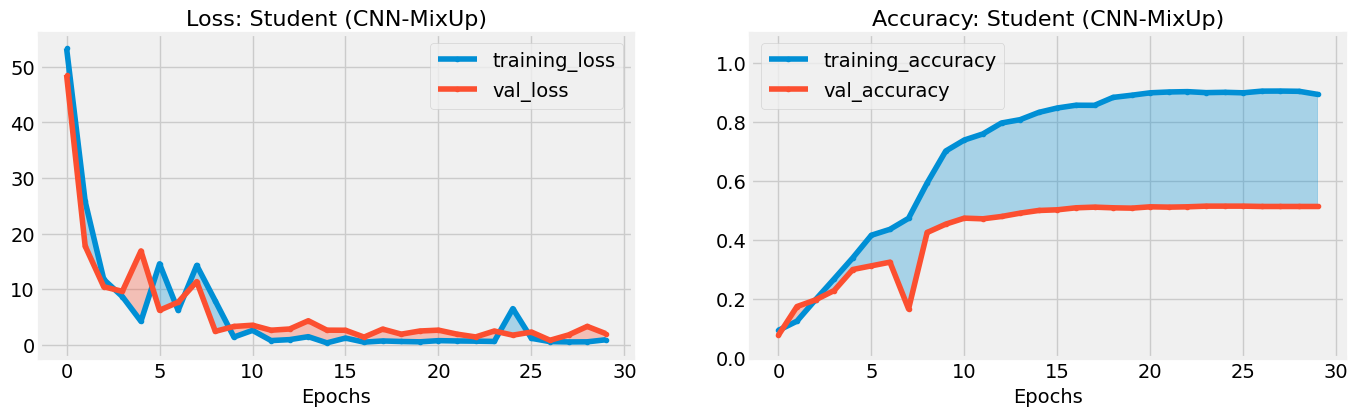

In [ ]:
plot_training_curves(history, 'Student (CNN-MixUp)', model_name='student')

### ▶ AugPip







In [ ]:
history = run_experiment(augpip_ds, val_ds_v, teacher, model_name='teacher')

Epoch 1/100
111/111 [==============================] - 78s 678ms/step - loss: 1920.5223 - accuracy: 0.0847 - top5-acc: 0.3720 - Brier score: 9938362.0000 - auc: 0.5288 - val_loss: 170.6971 - val_accuracy: 0.2593 - val_top5-acc: 0.6569 - val_Brier score: 90069.0391 - val_auc: 0.6483 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 78s 684ms/step - loss: 146.7350 - accuracy: 0.1993 - top5-acc: 0.5249 - Brier score: 32205.7617 - auc: 0.5702 - val_loss: 66.8857 - val_accuracy: 0.3522 - val_top5-acc: 0.6931 - val_Brier score: 12120.8486 - val_auc: 0.7154 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 77s 674ms/step - loss: 65.8464 - accuracy: 0.2896 - top5-acc: 0.6065 - Brier score: 9070.5137 - auc: 0.5929 - val_loss: 51.0858 - val_accuracy: 0.3794 - val_top5-acc: 0.7656 - val_Brier score: 11491.2705 - val_auc: 0.7471 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 77s 677ms/step - loss: 51.7341 - accuracy: 0.2947 - top5-acc: 0.656

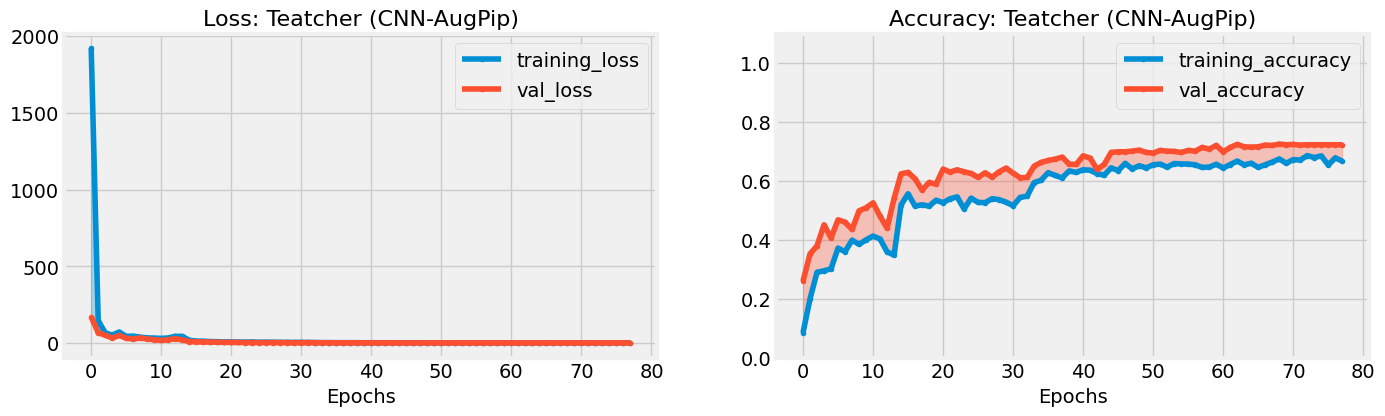

In [ ]:
plot_training_curves(history, 'Teatcher (CNN-AugPip)', model_name='teacher')

In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(augpip_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
111/111 [==============================] - 78s 670ms/step - accuracy: 0.0784 - top5-acc: 0.3364 - Brier score: 305629.5312 - auc: 0.5007 - student_loss: 500.5379 - distillation_loss: 835.4682 - val_accuracy: 0.1110 - val_top5-acc: 0.3817 - val_Brier score: 1275.1007 - val_auc: 0.5111 - val_student_loss: 24.1615 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 77s 671ms/step - accuracy: 0.1050 - top5-acc: 0.4057 - Brier score: 665.8067 - auc: 0.5155 - student_loss: 18.2187 - distillation_loss: 70.4784 - val_accuracy: 0.1767 - val_top5-acc: 0.5187 - val_Brier score: 395.8963 - val_auc: 0.5286 - val_student_loss: 15.9839 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 77s 675ms/step - accuracy: 0.1206 - top5-acc: 0.4360 - Brier score: 428.9512 - auc: 0.5151 - student_loss: 12.1942 - distillation_loss: 36.5029 - val_accuracy: 0.2084 - val_top5-acc: 0.5538 - val_Brier score: 268.5348 - val_auc: 0.5354 - val_student_loss: 6.2288 - lr: 0.0010

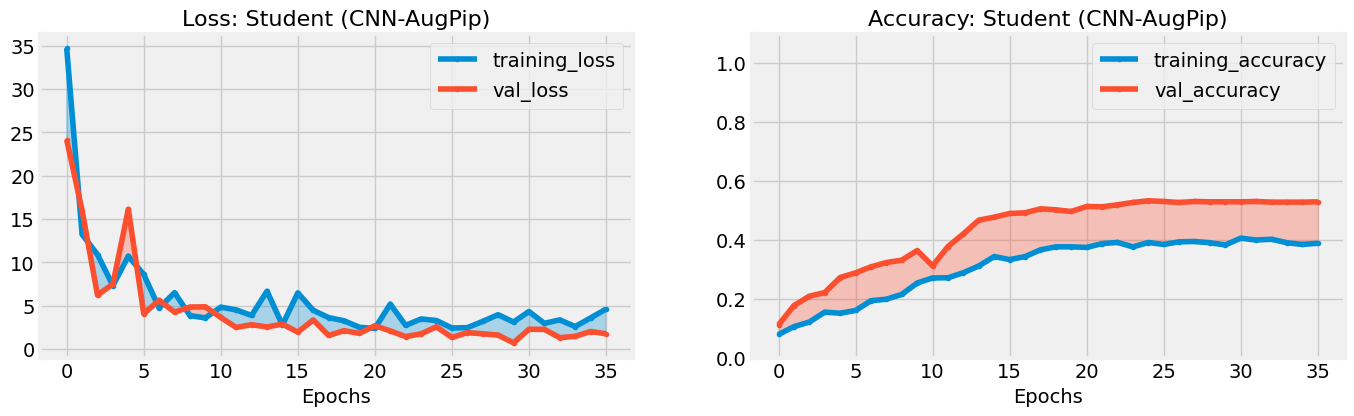

In [ ]:
plot_training_curves(history, 'Student (CNN-AugPip)', model_name='student')



---

##⏰ Flush

In [ ]:
del history
del teacher
del student



---



# 🔴 Transformer (neighborhood attention)



In [ ]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256
# AUGMENTATION
PATCH_SIZE = 6
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMG_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [ ]:
def create_transfomer(vanilla=False):
    inputs = layers.Input(shape=input_shape)

    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model



---



In [ ]:
#vanilla=False ====> transformer with self locality attention (neighborhood)
TRANSFORMER_LAYERS = 8
NUM_HEADS = 4
transformer_teacher = create_transfomer(vanilla=False)
#####################################################
TRANSFORMER_LAYERS = 4
NUM_HEADS = 2
transformer_student = create_transfomer(vanilla=False)

### ▶ AugMix







In [ ]:
history = run_experiment(augmix_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
111/111 [==============================] - 91s 656ms/step - loss: 6.9205 - accuracy: 0.1467 - top5-acc: 0.4757 - Brier score: 34.8497 - auc: 0.6060 - val_loss: 2.3230 - val_accuracy: 0.3035 - val_top5-acc: 0.6523 - val_Brier score: 3.2832 - val_auc: 0.7265 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 76s 667ms/step - loss: 2.9025 - accuracy: 0.2381 - top5-acc: 0.6036 - Brier score: 8.3735 - auc: 0.6836 - val_loss: 2.1023 - val_accuracy: 0.3715 - val_top5-acc: 0.6908 - val_Brier score: 2.5716 - val_auc: 0.7703 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 76s 661ms/step - loss: 2.2254 - accuracy: 0.3010 - top5-acc: 0.6713 - Brier score: 8.5270 - auc: 0.7253 - val_loss: 1.7905 - val_accuracy: 0.4292 - val_top5-acc: 0.7939 - val_Brier score: 3.6472 - val_auc: 0.8110 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 76s 659ms/step - loss: 1.9656 - accuracy: 0.3604 - top5-acc: 0.7160 - Brier score: 10.5461 - auc: 0.7

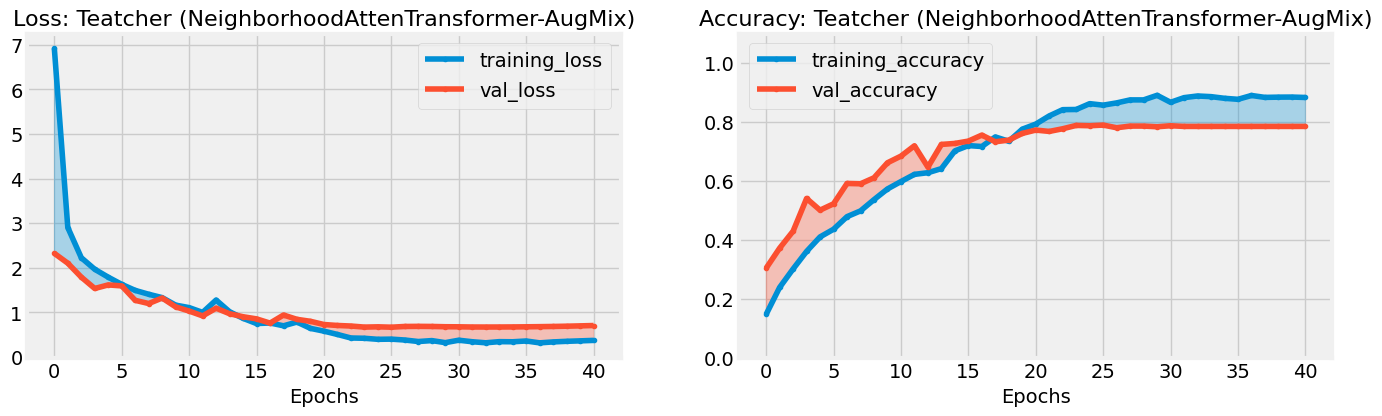

In [ ]:
plot_training_curves(history, 'Teatcher (NeighborhoodAttenTransformer-AugMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(augmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
111/111 [==============================] - 87s 604ms/step - accuracy: 0.2525 - top5-acc: 0.5929 - Brier score: 26.9648 - auc: 0.6679 - student_loss: 4.7678 - distillation_loss: 22.4745 - val_accuracy: 0.4507 - val_top5-acc: 0.8199 - val_Brier score: 12.9602 - val_auc: 0.8222 - val_student_loss: 2.1931 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 74s 646ms/step - accuracy: 0.3814 - top5-acc: 0.7438 - Brier score: 24.0644 - auc: 0.7429 - student_loss: 2.5247 - distillation_loss: 14.0090 - val_accuracy: 0.4972 - val_top5-acc: 0.8822 - val_Brier score: 11.7640 - val_auc: 0.8504 - val_student_loss: 2.6703 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 73s 640ms/step - accuracy: 0.4210 - top5-acc: 0.7766 - Brier score: 24.4707 - auc: 0.7675 - student_loss: 2.2169 - distillation_loss: 12.0277 - val_accuracy: 0.5583 - val_top5-acc: 0.8867 - val_Brier score: 14.0333 - val_auc: 0.8540 - val_student_loss: 1.9949 - lr: 0.0010
Epoch 4/100
111/

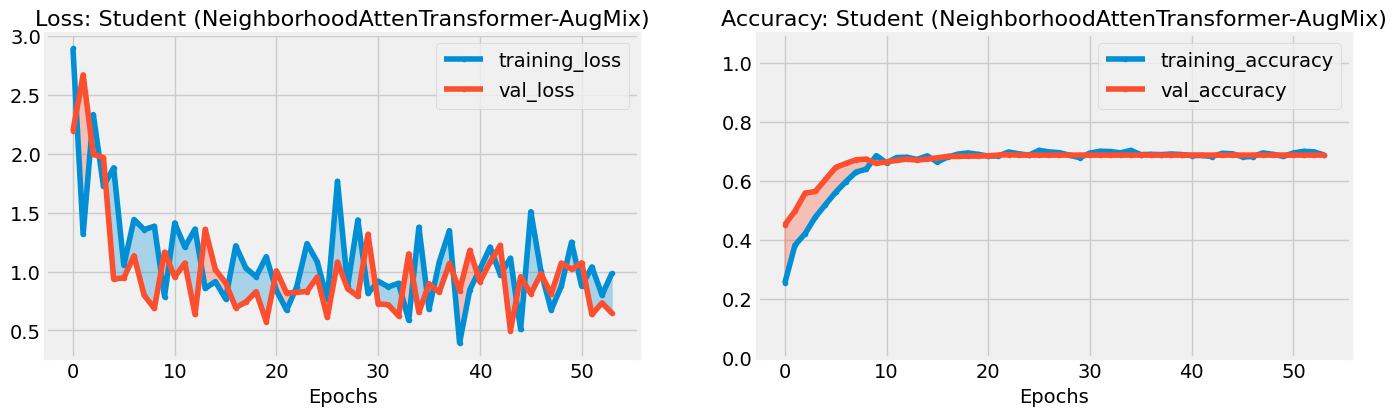

In [ ]:
plot_training_curves(history, 'Student (NeighborhoodAttenTransformer-AugMix)', model_name='student')

### ▶ CutMix







In [ ]:
history = run_experiment(cutmix_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
111/111 [==============================] - 59s 373ms/step - loss: 7.5299 - accuracy: 0.1452 - top5-acc: 0.4536 - Brier score: 33.0968 - auc: 0.5844 - val_loss: 2.4145 - val_accuracy: 0.2571 - val_top5-acc: 0.6149 - val_Brier score: 1.3290 - val_auc: 0.7118 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 42s 355ms/step - loss: 2.8428 - accuracy: 0.2087 - top5-acc: 0.5498 - Brier score: 5.3919 - auc: 0.6366 - val_loss: 2.2536 - val_accuracy: 0.3296 - val_top5-acc: 0.6750 - val_Brier score: 0.9795 - val_auc: 0.7456 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 42s 355ms/step - loss: 2.4718 - accuracy: 0.2378 - top5-acc: 0.6005 - Brier score: 5.1214 - auc: 0.6598 - val_loss: 1.9765 - val_accuracy: 0.3794 - val_top5-acc: 0.7407 - val_Brier score: 1.9215 - val_auc: 0.7882 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 42s 355ms/step - loss: 2.3968 - accuracy: 0.2653 - top5-acc: 0.6574 - Brier score: 6.3390 - auc: 0.68

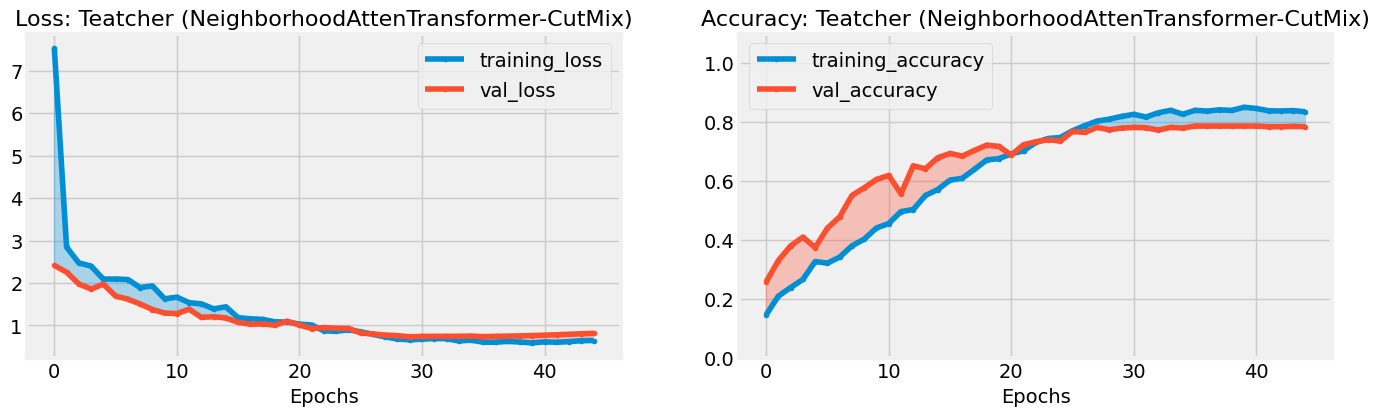

In [ ]:
plot_training_curves(history, 'Teatcher (NeighborhoodAttenTransformer-CutMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(cutmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
111/111 [==============================] - 46s 241ms/step - accuracy: 0.1583 - top5-acc: 0.5204 - Brier score: 8.3897 - auc: 0.6199 - student_loss: 3.8266 - distillation_loss: 6.1941 - val_accuracy: 0.3262 - val_top5-acc: 0.7690 - val_Brier score: 0.4295 - val_auc: 0.7874 - val_student_loss: 2.2072 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 27s 226ms/step - accuracy: 0.2684 - top5-acc: 0.6874 - Brier score: 2.9751 - auc: 0.7091 - student_loss: 2.3430 - distillation_loss: 2.9989 - val_accuracy: 0.4462 - val_top5-acc: 0.8482 - val_Brier score: 0.9538 - val_auc: 0.8374 - val_student_loss: 1.9884 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 26s 218ms/step - accuracy: 0.3230 - top5-acc: 0.7390 - Brier score: 3.0358 - auc: 0.7352 - student_loss: 2.1864 - distillation_loss: 2.7041 - val_accuracy: 0.5266 - val_top5-acc: 0.8766 - val_Brier score: 1.4260 - val_auc: 0.8593 - val_student_loss: 1.7984 - lr: 0.0010
Epoch 4/100
111/111 [====

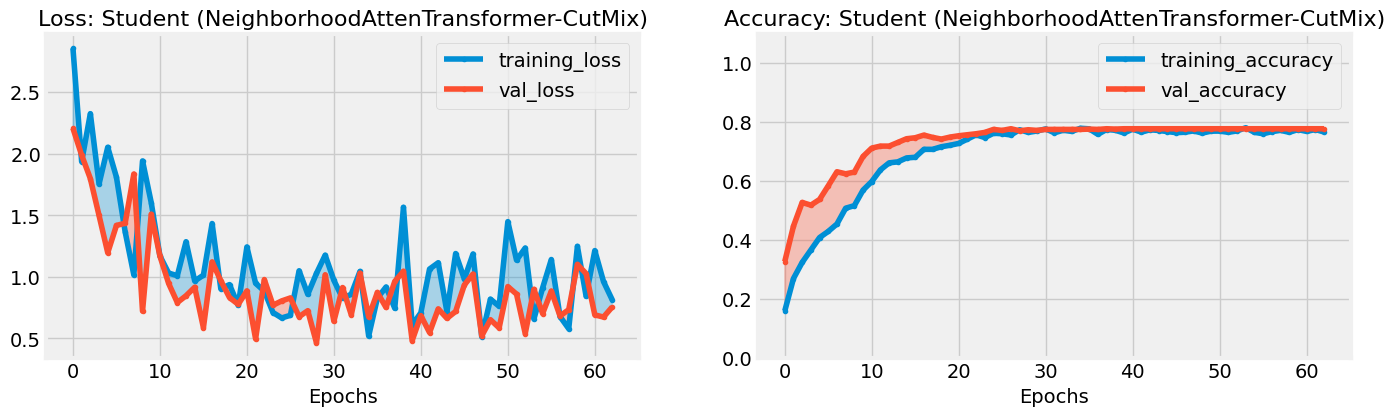

In [ ]:
plot_training_curves(history, 'Student (NeighborhoodAttenTransformer-CutMix)', model_name='student')

### ▶ MixUp







In [ ]:
history = run_experiment(mixup_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
111/111 [==============================] - 59s 373ms/step - loss: 8.7612 - accuracy: 0.1676 - top5-acc: 0.5088 - Brier score: 51.5500 - auc: 0.5837 - val_loss: 2.3627 - val_accuracy: 0.2933 - val_top5-acc: 0.5900 - val_Brier score: 2.9355 - val_auc: 0.7022 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 41s 355ms/step - loss: 3.0593 - accuracy: 0.2409 - top5-acc: 0.6084 - Brier score: 8.6414 - auc: 0.6308 - val_loss: 2.1142 - val_accuracy: 0.3749 - val_top5-acc: 0.7293 - val_Brier score: 2.7646 - val_auc: 0.7779 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 41s 355ms/step - loss: 2.3963 - accuracy: 0.3199 - top5-acc: 0.7061 - Brier score: 9.0399 - auc: 0.6609 - val_loss: 1.8576 - val_accuracy: 0.4643 - val_top5-acc: 0.8279 - val_Brier score: 1.6942 - val_auc: 0.8146 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 41s 351ms/step - loss: 2.0578 - accuracy: 0.3743 - top5-acc: 0.7494 - Brier score: 7.7313 - auc: 0.68

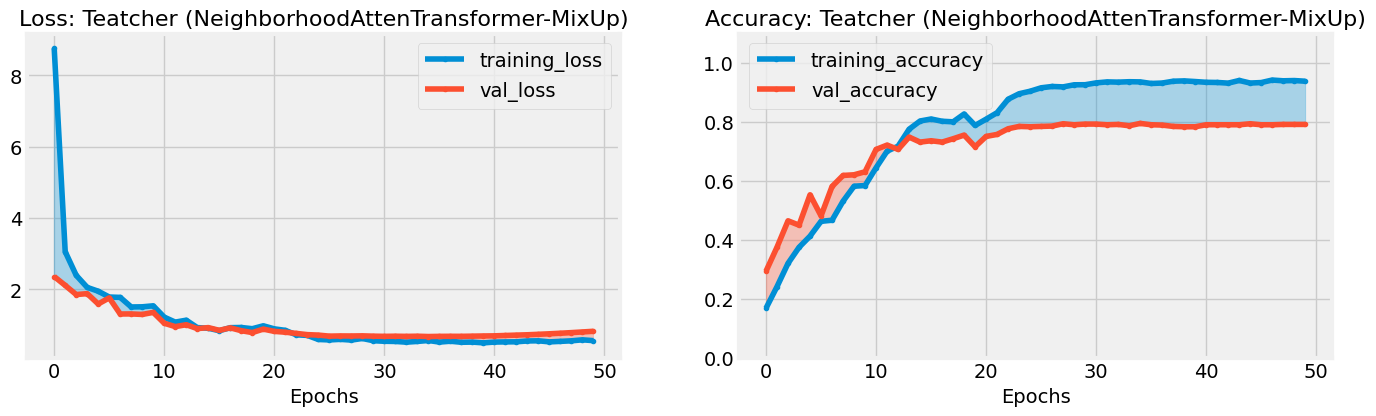

In [ ]:
plot_training_curves(history, 'Teatcher (NeighborhoodAttenTransformer-MixUp)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(mixup_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
111/111 [==============================] - 46s 242ms/step - accuracy: 0.1580 - top5-acc: 0.5167 - Brier score: 10.8902 - auc: 0.6089 - student_loss: 3.9382 - distillation_loss: 5.8127 - val_accuracy: 0.2809 - val_top5-acc: 0.7089 - val_Brier score: 0.2690 - val_auc: 0.7600 - val_student_loss: 2.1262 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 27s 226ms/step - accuracy: 0.2398 - top5-acc: 0.6653 - Brier score: 2.0833 - auc: 0.6773 - student_loss: 2.4595 - distillation_loss: 2.0125 - val_accuracy: 0.3239 - val_top5-acc: 0.7327 - val_Brier score: 0.6691 - val_auc: 0.7897 - val_student_loss: 2.3332 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 27s 226ms/step - accuracy: 0.3330 - top5-acc: 0.7475 - Brier score: 2.0597 - auc: 0.7138 - student_loss: 2.1334 - distillation_loss: 1.7009 - val_accuracy: 0.4315 - val_top5-acc: 0.8245 - val_Brier score: 1.0034 - val_auc: 0.8425 - val_student_loss: 1.8173 - lr: 0.0010
Epoch 4/100
111/111 [===

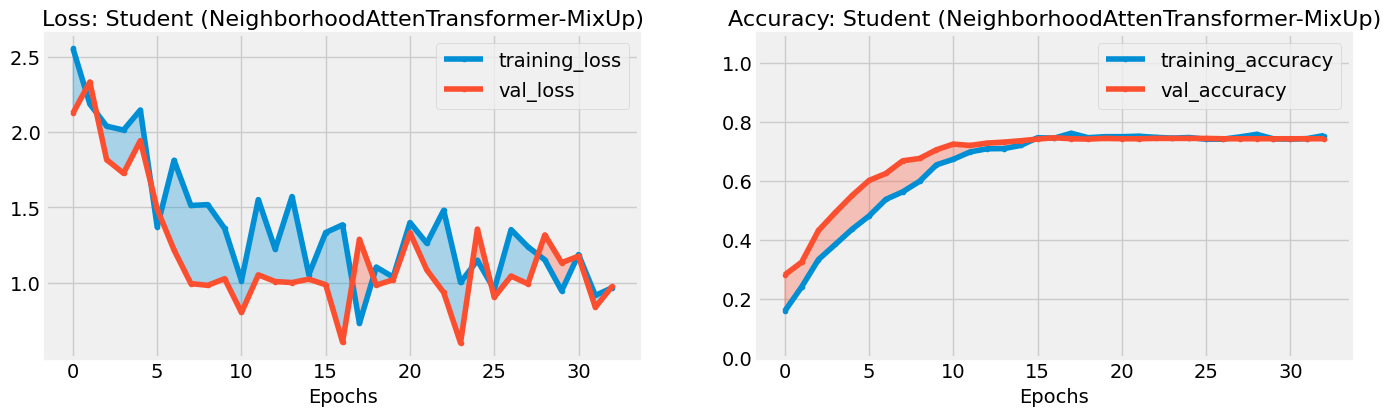

In [ ]:
plot_training_curves(history, 'Student (NeighborhoodAttenTransformer-MixUp)', model_name='student')

### ▶ AugPip







In [ ]:
history = run_experiment(augpip_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
111/111 [==============================] - 95s 689ms/step - loss: 7.4832 - accuracy: 0.1050 - top5-acc: 0.4111 - Brier score: 44.2788 - auc: 0.5554 - val_loss: 2.6046 - val_accuracy: 0.2163 - val_top5-acc: 0.5742 - val_Brier score: 1.9436 - val_auc: 0.6775 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 81s 709ms/step - loss: 2.9759 - accuracy: 0.1365 - top5-acc: 0.4669 - Brier score: 2.4125 - auc: 0.5691 - val_loss: 2.4789 - val_accuracy: 0.2061 - val_top5-acc: 0.5243 - val_Brier score: 1.1237 - val_auc: 0.6588 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 81s 703ms/step - loss: 2.7647 - accuracy: 0.1356 - top5-acc: 0.4635 - Brier score: 1.6270 - auc: 0.5718 - val_loss: 2.3681 - val_accuracy: 0.2695 - val_top5-acc: 0.6387 - val_Brier score: 0.7658 - val_auc: 0.7252 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 81s 710ms/step - loss: 2.6925 - accuracy: 0.1501 - top5-acc: 0.4830 - Brier score: 1.6143 - auc: 0.58

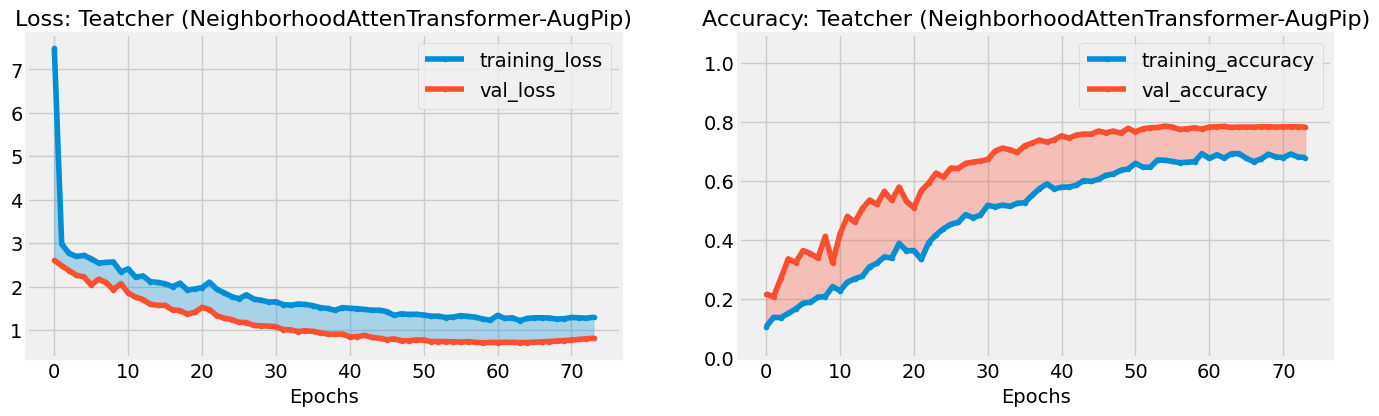

In [ ]:
plot_training_curves(history, 'Teatcher (NeighborhoodAttenTransformer-AugPip)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(augpip_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
111/111 [==============================] - 92s 653ms/step - accuracy: 0.1200 - top5-acc: 0.4595 - Brier score: 8.6003 - auc: 0.5875 - student_loss: 3.7166 - distillation_loss: 3.9232 - val_accuracy: 0.2401 - val_top5-acc: 0.6682 - val_Brier score: 0.3818 - val_auc: 0.7449 - val_student_loss: 2.5420 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 79s 689ms/step - accuracy: 0.1826 - top5-acc: 0.6022 - Brier score: 1.2061 - auc: 0.6455 - student_loss: 2.5677 - distillation_loss: 1.1328 - val_accuracy: 0.3035 - val_top5-acc: 0.7803 - val_Brier score: 0.3115 - val_auc: 0.8041 - val_student_loss: 2.3539 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 79s 692ms/step - accuracy: 0.2163 - top5-acc: 0.6424 - Brier score: 1.1426 - auc: 0.6570 - student_loss: 2.4720 - distillation_loss: 1.0428 - val_accuracy: 0.3884 - val_top5-acc: 0.8324 - val_Brier score: 0.3569 - val_auc: 0.8253 - val_student_loss: 2.2489 - lr: 0.0010
Epoch 4/100
111/111 [====

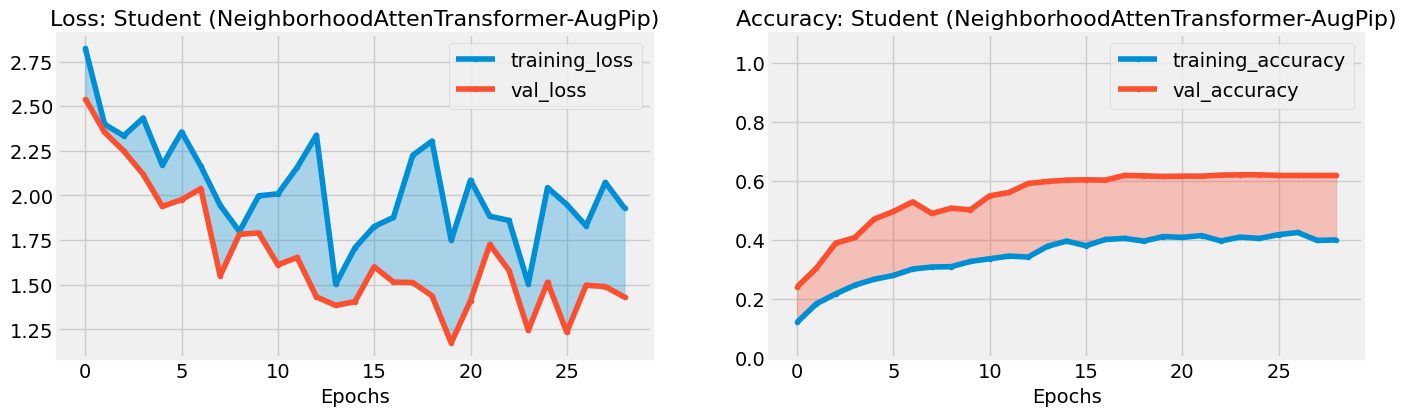

In [ ]:
plot_training_curves(history, 'Student (NeighborhoodAttenTransformer-AugPip)', model_name='student')



---



# 📂 Load BTDS-44C

In [ ]:
##################
NUM_CLASSES = 44
##################
path = '/content/drive/MyDrive/Multiclass_Brain_Tumor_MRI/MRI_44Classes/'
# train data
train_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 4478 files belonging to 44 classes.
Using 3583 files for training.
Found 4478 files belonging to 44 classes.
Using 895 files for validation.


## ◼ Class Weighting

In [ ]:
#label_mode='categorical',
train_ds_cat = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
)
class_names = train_ds_cat.class_names
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(NUM_CLASSES): classes.append(i)
class_weights=compute_class_weight(class_weight="balanced",classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

Found 4478 files belonging to 44 classes.


{0: 0.57838326446281,
 1: 0.4368903628560281,
 2: 0.5952950558213717,
 3: 1.5423553719008265,
 4: 0.908887987012987,
 5: 1.3944582814445827,
 6: 2.262121212121212,
 7: 2.1207386363636362,
 8: 1.7858851674641147,
 9: 5.089772727272727,
 10: 5.65530303030303,
 11: 4.425889328063241,
 12: 3.7702020202020203,
 13: 2.5448863636363637,
 14: 3.084710743801653,
 15: 1.8508264462809918,
 16: 1.0829303675048356,
 17: 1.8508264462809918,
 18: 3.393181818181818,
 19: 3.283724340175953,
 20: 5.987967914438503,
 21: 4.425889328063241,
 22: 1.5193351424694708,
 23: 2.4828159645232817,
 24: 0.37424799465240643,
 25: 0.27586844050258685,
 26: 0.4368903628560281,
 27: 0.7830419580419581,
 28: 0.4564818589482267,
 29: 0.9788024475524476,
 30: 1.1836680761099365,
 31: 1.4138257575757576,
 32: 1.5423553719008265,
 33: 1.5423553719008265,
 34: 0.9425505050505051,
 35: 1.6158008658008658,
 36: 0.6878071253071253,
 37: 0.5247188378631678,
 38: 0.8276053215077606,
 39: 3.635551948051948,
 40: 1.211850649350649

# 🅰 Data augmentation

In the original paper, the authors use AutoAugment to induce stronger regularization. For this example, we will be using the standard geometric augmentations like random cropping and flipping. https://arxiv.org/abs/1805.09501

In [ ]:
def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, NUM_CLASSES)
    return {"images": image, "labels": label}

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

augmix = keras_cv.layers.AugMix([0, 255])
mixup = keras_cv.layers.MixUp()
cutmix = keras_cv.layers.CutMix(alpha=0.02)

#No augmentation
train_ds_v = train_ds.map(to_dict)
train_ds_v = train_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
train_ds_v = train_ds_v.prefetch(AUTOTUNE)
val_ds_v = val_ds.map(to_dict)
val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
val_ds_v = val_ds_v.prefetch(AUTOTUNE) #Use this for fit

In [ ]:
def aug_pipeline1(samples):
    samples = augmix(samples, training=True)
    return samples
def aug_pipeline2(samples):
    samples = mixup(samples, training=True)
    return samples
def aug_pipeline3(samples):
    samples = cutmix(samples, training=True)
    return samples
def aug_pipeline(samples):
    samples = augmix(samples, training=True)
    samples = mixup(samples, training=True)
    samples = cutmix(samples, training=True)
    return samples
#AugMix
augmix_ds = train_ds.shuffle(1000).map(to_dict)
augmix_ds = augmix_ds.map(aug_pipeline1)
augmix_ds = augmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
augmix_ds = augmix_ds.prefetch(AUTOTUNE) #Use this for fit
#MixUp
mixup_ds = train_ds.shuffle(1000).map(to_dict)
mixup_ds = mixup_ds.map(aug_pipeline2)
mixup_ds = mixup_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
mixup_ds = mixup_ds.prefetch(AUTOTUNE) #Use this for fit
#CutMix
cutmix_ds = train_ds.shuffle(1000).map(to_dict)
cutmix_ds = cutmix_ds.map(aug_pipeline3)
cutmix_ds = cutmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
cutmix_ds = cutmix_ds.prefetch(AUTOTUNE) #Use this for fit
#AugPip
augpip_ds = train_ds.shuffle(1000).map(to_dict)
augpip_ds = augpip_ds.map(aug_pipeline)
augpip_ds = augpip_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
augpip_ds = augpip_ds.prefetch(AUTOTUNE) #Use this for fit

## ◼ CNN

In [ ]:
# Create the teacher
teacher = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(NUM_CLASSES),
    ],
    name="teacher",
)
# Create the student
student = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dense(NUM_CLASSES),
    ],
    name="student",
)

### ▶ AugMix







In [ ]:
history = run_experiment(augmix_ds, val_ds_v, teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 400s 1s/step - loss: 1690.9941 - accuracy: 0.0999 - top5-acc: 0.2568 - Brier score: 5606876.5000 - auc: 0.5567 - val_loss: 206.6523 - val_accuracy: 0.2704 - val_top5-acc: 0.5117 - val_Brier score: 57622.5430 - val_auc: 0.6483 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 73s 633ms/step - loss: 120.0373 - accuracy: 0.3503 - top5-acc: 0.5903 - Brier score: 53538.7852 - auc: 0.6844 - val_loss: 135.7919 - val_accuracy: 0.3564 - val_top5-acc: 0.5978 - val_Brier score: 38021.6094 - val_auc: 0.7418 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 73s 632ms/step - loss: 91.0266 - accuracy: 0.4644 - top5-acc: 0.6980 - Brier score: 45603.8789 - auc: 0.7203 - val_loss: 104.8544 - val_accuracy: 0.4480 - val_top5-acc: 0.7419 - val_Brier score: 35239.1055 - val_auc: 0.7311 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 73s 630ms/step - loss: 68.7306 - accuracy: 0.5440 - top5-acc: 0.76

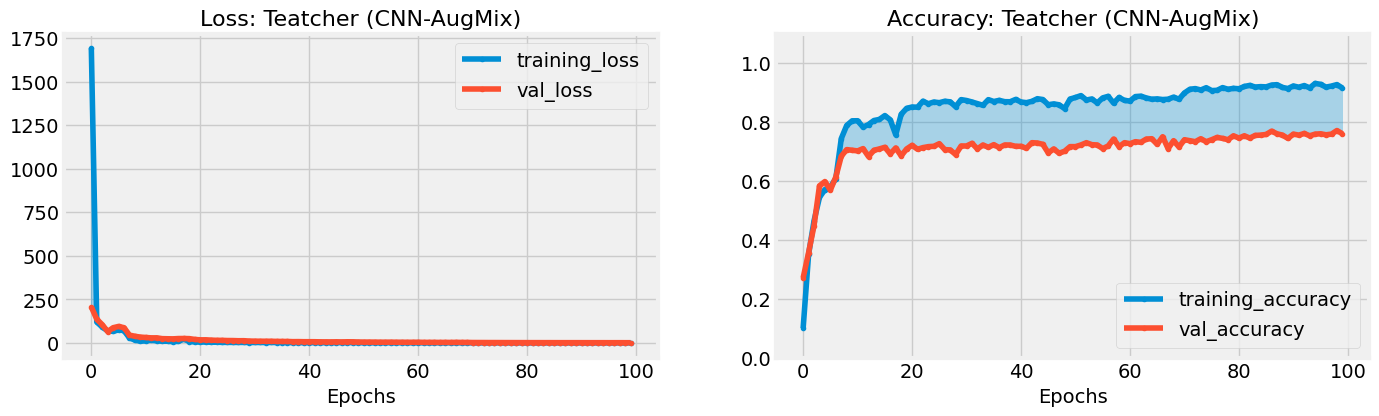

In [ ]:
plot_training_curves(history, 'Teatcher (CNN-AugMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(augmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 74s 618ms/step - accuracy: 0.0544 - top5-acc: 0.1831 - Brier score: 323386.4688 - auc: 0.5101 - student_loss: 451.2660 - distillation_loss: 936.8370 - val_accuracy: 0.1039 - val_top5-acc: 0.2536 - val_Brier score: 3166.4207 - val_auc: 0.5225 - val_student_loss: 66.1429 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 73s 631ms/step - accuracy: 0.1541 - top5-acc: 0.3307 - Brier score: 1392.9678 - auc: 0.5362 - student_loss: 32.2269 - distillation_loss: 190.1338 - val_accuracy: 0.2056 - val_top5-acc: 0.4771 - val_Brier score: 486.4109 - val_auc: 0.5490 - val_student_loss: 20.0616 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 72s 628ms/step - accuracy: 0.2476 - top5-acc: 0.4569 - Brier score: 459.6021 - auc: 0.5404 - student_loss: 14.0264 - distillation_loss: 64.8690 - val_accuracy: 0.2492 - val_top5-acc: 0.5151 - val_Brier score: 313.5813 - val_auc: 0.5337 - val_student_loss: 10.7366 - lr: 0.0

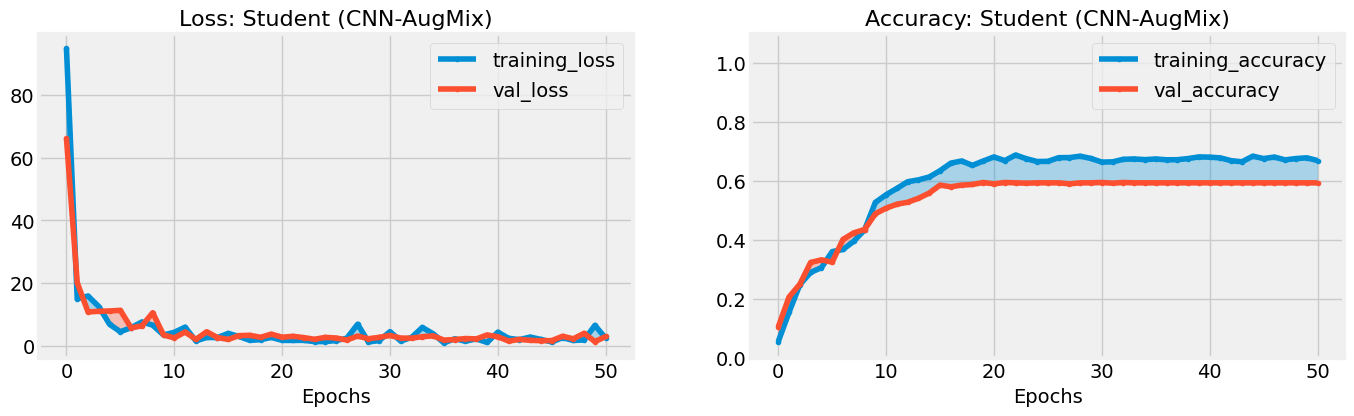

In [ ]:
plot_training_curves(history, 'Student (CNN-AugMix)', model_name='student')

### ▶ CutMix







In [ ]:
history = run_experiment(cutmix_ds, val_ds_v, teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 314s 557ms/step - loss: 1565.3346 - accuracy: 0.1055 - top5-acc: 0.2626 - Brier score: 4528086.5000 - auc: 0.5630 - val_loss: 200.3325 - val_accuracy: 0.3095 - val_top5-acc: 0.5039 - val_Brier score: 81136.9141 - val_auc: 0.6935 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 7s 45ms/step - loss: 152.2885 - accuracy: 0.3221 - top5-acc: 0.5710 - Brier score: 74617.3047 - auc: 0.6365 - val_loss: 84.5389 - val_accuracy: 0.4581 - val_top5-acc: 0.6894 - val_Brier score: 26203.1348 - val_auc: 0.6656 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 7s 46ms/step - loss: 57.3435 - accuracy: 0.4887 - top5-acc: 0.7449 - Brier score: 17518.4648 - auc: 0.7013 - val_loss: 67.3428 - val_accuracy: 0.4704 - val_top5-acc: 0.6804 - val_Brier score: 24388.3594 - val_auc: 0.6150 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 7s 44ms/step - loss: 56.6047 - accuracy: 0.4996 - top5-acc: 0.7497 - 

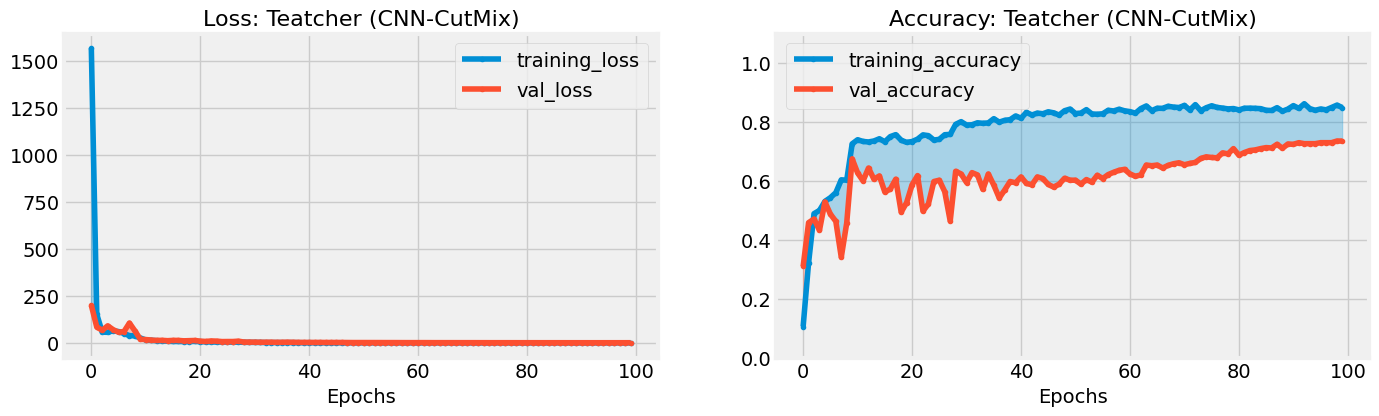

In [ ]:
plot_training_curves(history, 'Teatcher (CNN-CutMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(cutmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 10s 45ms/step - accuracy: 0.0466 - top5-acc: 0.1524 - Brier score: 364157.5312 - auc: 0.5212 - student_loss: 655.9900 - distillation_loss: 1082.8872 - val_accuracy: 0.0525 - val_top5-acc: 0.2145 - val_Brier score: 19370.1523 - val_auc: 0.5331 - val_student_loss: 256.0697 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 7s 45ms/step - accuracy: 0.0544 - top5-acc: 0.1881 - Brier score: 9228.3213 - auc: 0.5293 - student_loss: 92.3577 - distillation_loss: 477.9806 - val_accuracy: 0.0659 - val_top5-acc: 0.1966 - val_Brier score: 738.8301 - val_auc: 0.5311 - val_student_loss: 30.5011 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 7s 45ms/step - accuracy: 0.0834 - top5-acc: 0.2456 - Brier score: 466.9640 - auc: 0.5300 - student_loss: 19.9503 - distillation_loss: 64.6396 - val_accuracy: 0.1006 - val_top5-acc: 0.2726 - val_Brier score: 313.2355 - val_auc: 0.5337 - val_student_loss: 15.7555 - lr: 0.001

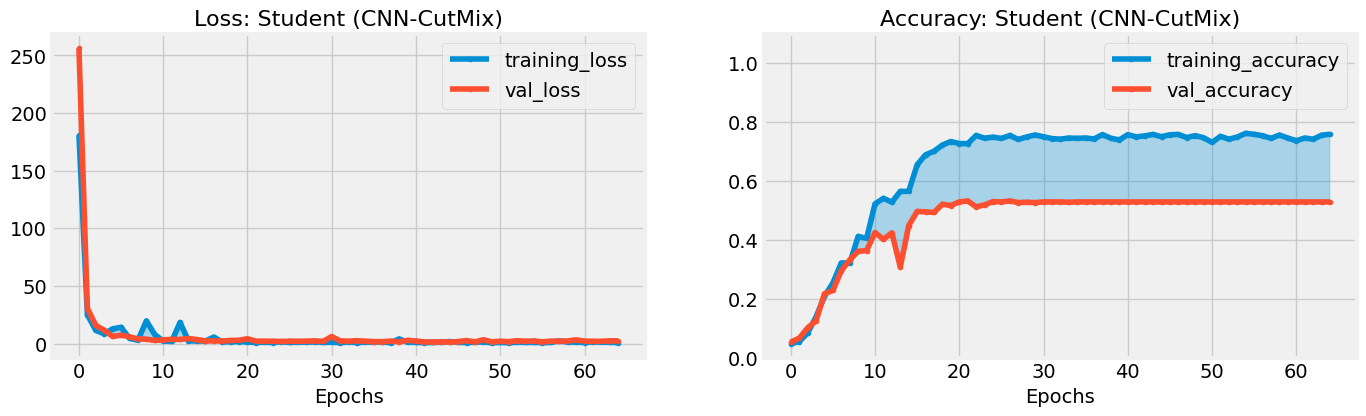

In [ ]:
plot_training_curves(history, 'Student (CNN-CutMix)', model_name='student')

### ▶ MixUp







In [ ]:
history = run_experiment(mixup_ds, val_ds_v, teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 8s 47ms/step - loss: 1811.3271 - accuracy: 0.1315 - top5-acc: 0.3064 - Brier score: 7342386.0000 - auc: 0.5488 - val_loss: 176.5295 - val_accuracy: 0.3419 - val_top5-acc: 0.5765 - val_Brier score: 71576.5703 - val_auc: 0.7332 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 7s 43ms/step - loss: 101.1391 - accuracy: 0.4655 - top5-acc: 0.7067 - Brier score: 41583.5000 - auc: 0.6611 - val_loss: 96.4628 - val_accuracy: 0.4380 - val_top5-acc: 0.6682 - val_Brier score: 21119.9668 - val_auc: 0.6830 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 7s 43ms/step - loss: 52.2360 - accuracy: 0.5967 - top5-acc: 0.8060 - Brier score: 21506.4766 - auc: 0.6780 - val_loss: 56.3986 - val_accuracy: 0.4804 - val_top5-acc: 0.7486 - val_Brier score: 18577.1348 - val_auc: 0.8058 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 7s 42ms/step - loss: 47.6972 - accuracy: 0.6330 - top5-acc: 0.8261 - Bri

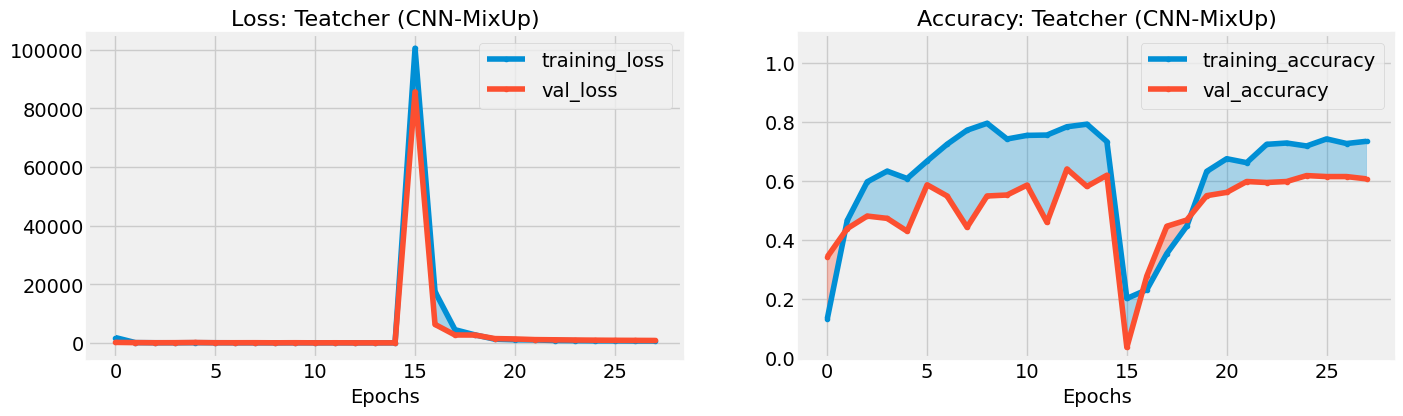

In [ ]:
plot_training_curves(history, 'Teatcher (CNN-MixUp)', model_name='teacher')

In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(mixup_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 7s 29ms/step - accuracy: 0.1264 - top5-acc: 0.2836 - Brier score: 392913.5000 - auc: 0.5689 - student_loss: 780.8081 - distillation_loss: 1274.0328 - val_accuracy: 0.2939 - val_top5-acc: 0.5307 - val_Brier score: 66474.4766 - val_auc: 0.6938 - val_student_loss: 251.1038 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 5s 24ms/step - accuracy: 0.3606 - top5-acc: 0.5574 - Brier score: 125250.3672 - auc: 0.6370 - student_loss: 340.0625 - distillation_loss: 890.3712 - val_accuracy: 0.2022 - val_top5-acc: 0.3453 - val_Brier score: 175075.9219 - val_auc: 0.5887 - val_student_loss: 635.6346 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 5s 26ms/step - accuracy: 0.4630 - top5-acc: 0.6553 - Brier score: 93464.8906 - auc: 0.6592 - student_loss: 246.4472 - distillation_loss: 720.9272 - val_accuracy: 0.4726 - val_top5-acc: 0.6603 - val_Brier score: 49160.2812 - val_auc: 0.7157 - val_student_loss: 196.357

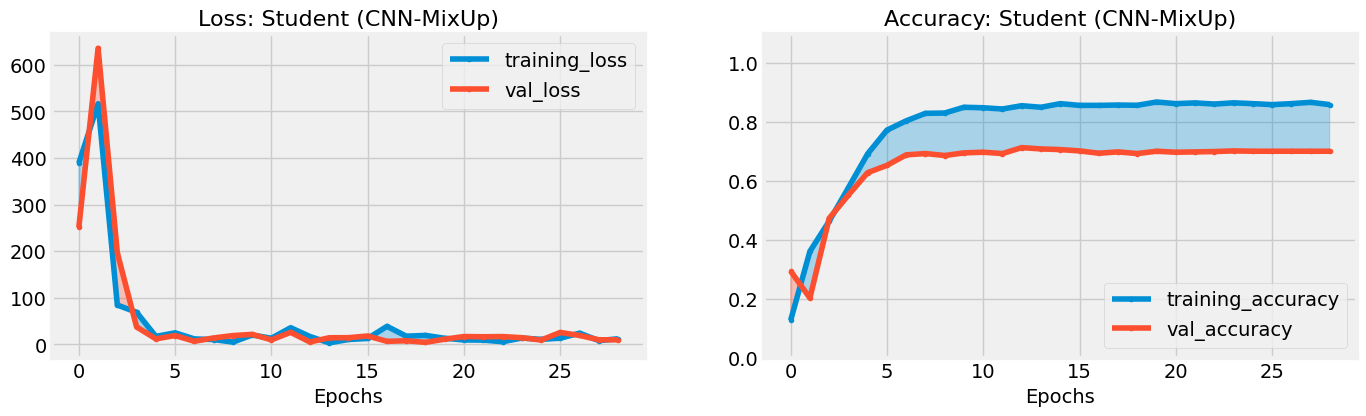

In [ ]:
plot_training_curves(history, 'Student (CNN-MixUp)', model_name='student')

### ▶ AugPip







In [ ]:
history = run_experiment(augpip_ds, val_ds_v, teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 78s 676ms/step - loss: 1514.1440 - accuracy: 0.0603 - top5-acc: 0.1859 - Brier score: 4002390.5000 - auc: 0.5189 - val_loss: 291.6896 - val_accuracy: 0.1587 - val_top5-acc: 0.3430 - val_Brier score: 61908.4883 - val_auc: 0.6213 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 78s 674ms/step - loss: 226.3786 - accuracy: 0.1471 - top5-acc: 0.3416 - Brier score: 44845.5898 - auc: 0.5768 - val_loss: 141.7735 - val_accuracy: 0.3318 - val_top5-acc: 0.5944 - val_Brier score: 33881.9766 - val_auc: 0.6849 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 77s 671ms/step - loss: 190.1425 - accuracy: 0.1954 - top5-acc: 0.4159 - Brier score: 48955.0781 - auc: 0.5894 - val_loss: 151.8314 - val_accuracy: 0.3184 - val_top5-acc: 0.5453 - val_Brier score: 57548.2109 - val_auc: 0.7357 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 78s 679ms/step - loss: 220.7872 - accuracy: 0.2294 - top5-acc: 

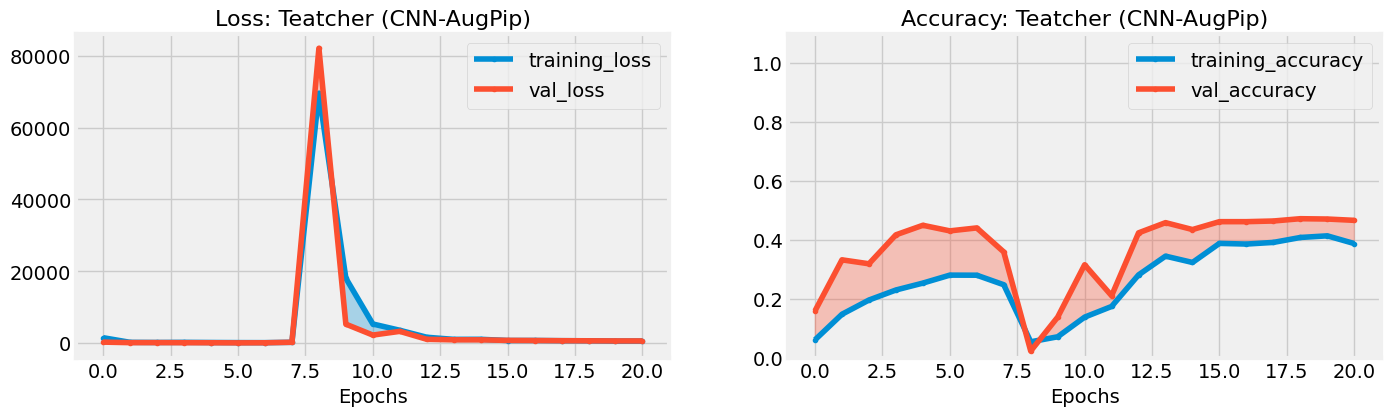

In [ ]:
plot_training_curves(history, 'Teatcher (CNN-AugPip)', model_name='teacher')

In [ ]:
distiller = Distiller(student=student, teacher=teacher)
history = run_experiment(augpip_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 79s 673ms/step - accuracy: 0.0851 - top5-acc: 0.2289 - Brier score: 67236.0312 - auc: 0.5384 - student_loss: 251.0959 - distillation_loss: 741.5852 - val_accuracy: 0.3196 - val_top5-acc: 0.4860 - val_Brier score: 4745.3560 - val_auc: 0.6753 - val_student_loss: 113.9510 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 78s 675ms/step - accuracy: 0.1898 - top5-acc: 0.3732 - Brier score: 4286.4604 - auc: 0.5758 - student_loss: 89.0930 - distillation_loss: 295.7876 - val_accuracy: 0.3531 - val_top5-acc: 0.5453 - val_Brier score: 4875.0737 - val_auc: 0.6956 - val_student_loss: 87.4831 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 77s 673ms/step - accuracy: 0.2163 - top5-acc: 0.4013 - Brier score: 3680.1719 - auc: 0.5896 - student_loss: 74.6270 - distillation_loss: 193.2661 - val_accuracy: 0.3631 - val_top5-acc: 0.5575 - val_Brier score: 4792.6592 - val_auc: 0.7141 - val_student_loss: 51.8646 - lr:

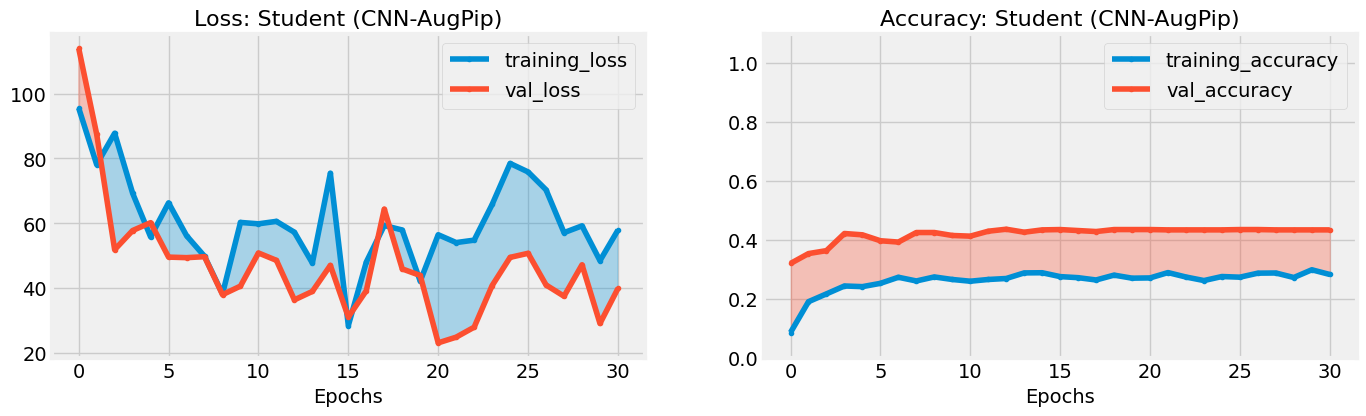

In [ ]:
plot_training_curves(history, 'Student (CNN-AugPip)', model_name='student')



---

##⏰ Flush

In [ ]:
del history
del teacher
del student



---



# 🔴 Transformer (neighborhood attention)







In [ ]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
PATCH_SIZE = 6
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMG_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [ ]:
def create_transfomer(vanilla=False):
    inputs = layers.Input(shape=input_shape)

    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model



---



In [ ]:
#vanilla=False ====> transformer with self locality attention (neighborhood)
TRANSFORMER_LAYERS = 8
NUM_HEADS = 4
transformer_teacher = create_transfomer(vanilla=False)
#####################################################
TRANSFORMER_LAYERS = 4
NUM_HEADS = 2
transformer_student = create_transfomer(vanilla=False)

### ▶ AugMix







In [ ]:
history = run_experiment(augmix_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 91s 655ms/step - loss: 7.8715 - accuracy: 0.0804 - top5-acc: 0.2361 - Brier score: 21.7294 - auc: 0.5911 - val_loss: 3.5554 - val_accuracy: 0.1162 - val_top5-acc: 0.2715 - val_Brier score: 0.5042 - val_auc: 0.6100 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 78s 672ms/step - loss: 3.7497 - accuracy: 0.1033 - top5-acc: 0.2735 - Brier score: 4.2830 - auc: 0.6280 - val_loss: 3.4278 - val_accuracy: 0.1441 - val_top5-acc: 0.3285 - val_Brier score: 0.6283 - val_auc: 0.6487 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 78s 677ms/step - loss: 3.6103 - accuracy: 0.1161 - top5-acc: 0.2788 - Brier score: 5.1228 - auc: 0.6327 - val_loss: 3.3343 - val_accuracy: 0.1508 - val_top5-acc: 0.3095 - val_Brier score: 0.8763 - val_auc: 0.6612 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 78s 675ms/step - loss: 3.2644 - accuracy: 0.1426 - top5-acc: 0.3316 - Brier score: 6.2673 - auc: 0.65

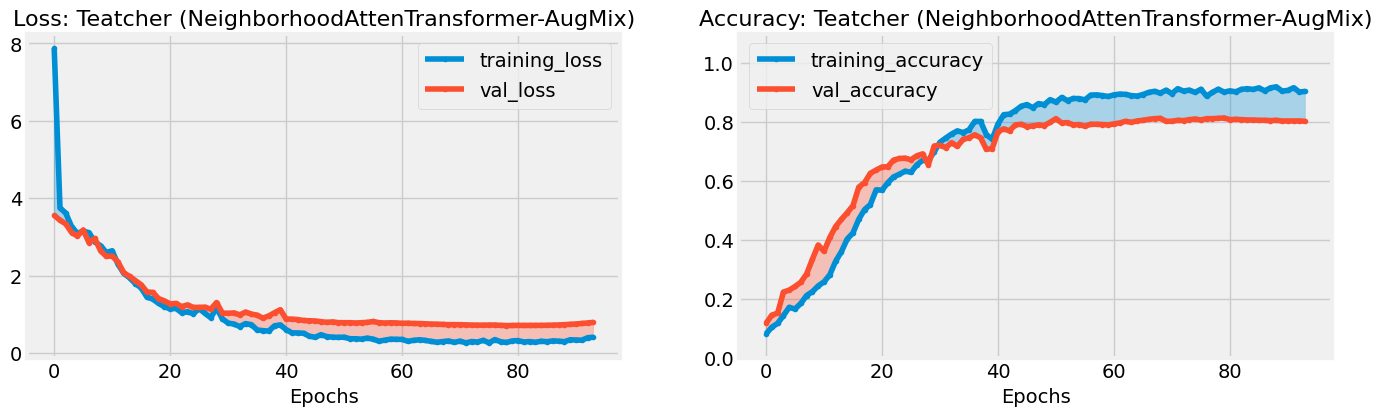

In [ ]:
plot_training_curves(history, 'Teatcher (NeighborhoodAttenTransformer-AugMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(augmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 88s 607ms/step - accuracy: 0.1460 - top5-acc: 0.3628 - Brier score: 8.2769 - auc: 0.6724 - student_loss: 4.3703 - distillation_loss: 11.6366 - val_accuracy: 0.3218 - val_top5-acc: 0.6145 - val_Brier score: 2.8718 - val_auc: 0.8041 - val_student_loss: 2.3492 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 75s 647ms/step - accuracy: 0.2289 - top5-acc: 0.4946 - Brier score: 6.8857 - auc: 0.7406 - student_loss: 3.2208 - distillation_loss: 9.4044 - val_accuracy: 0.3363 - val_top5-acc: 0.6346 - val_Brier score: 4.2859 - val_auc: 0.8174 - val_student_loss: 2.4618 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 76s 656ms/step - accuracy: 0.2677 - top5-acc: 0.5442 - Brier score: 7.6462 - auc: 0.7688 - student_loss: 2.9942 - distillation_loss: 8.5025 - val_accuracy: 0.4212 - val_top5-acc: 0.7307 - val_Brier score: 3.7235 - val_auc: 0.8566 - val_student_loss: 2.2063 - lr: 0.0010
Epoch 4/100
112/112 [===

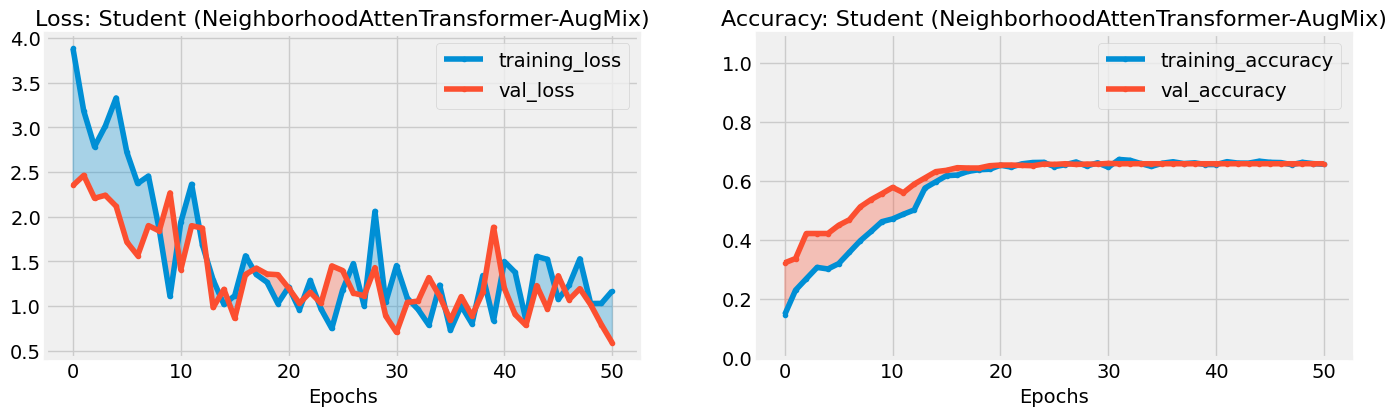

In [ ]:
plot_training_curves(history, 'Student (NeighborhoodAttenTransformer-AugMix)', model_name='student')

### ▶ CutMix







In [ ]:
history = run_experiment(cutmix_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 59s 376ms/step - loss: 8.6543 - accuracy: 0.0597 - top5-acc: 0.2001 - Brier score: 25.3577 - auc: 0.5678 - val_loss: 3.6195 - val_accuracy: 0.0726 - val_top5-acc: 0.2480 - val_Brier score: 0.8013 - val_auc: 0.5971 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 42s 357ms/step - loss: 3.9894 - accuracy: 0.0723 - top5-acc: 0.2104 - Brier score: 2.9444 - auc: 0.5749 - val_loss: 3.5681 - val_accuracy: 0.0905 - val_top5-acc: 0.2603 - val_Brier score: 0.3787 - val_auc: 0.5854 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 42s 357ms/step - loss: 3.7512 - accuracy: 0.0737 - top5-acc: 0.2143 - Brier score: 2.9299 - auc: 0.5697 - val_loss: 3.4843 - val_accuracy: 0.1374 - val_top5-acc: 0.2737 - val_Brier score: 0.4217 - val_auc: 0.6212 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 42s 358ms/step - loss: 3.5115 - accuracy: 0.0982 - top5-acc: 0.2386 - Brier score: 3.2687 - auc: 0.59

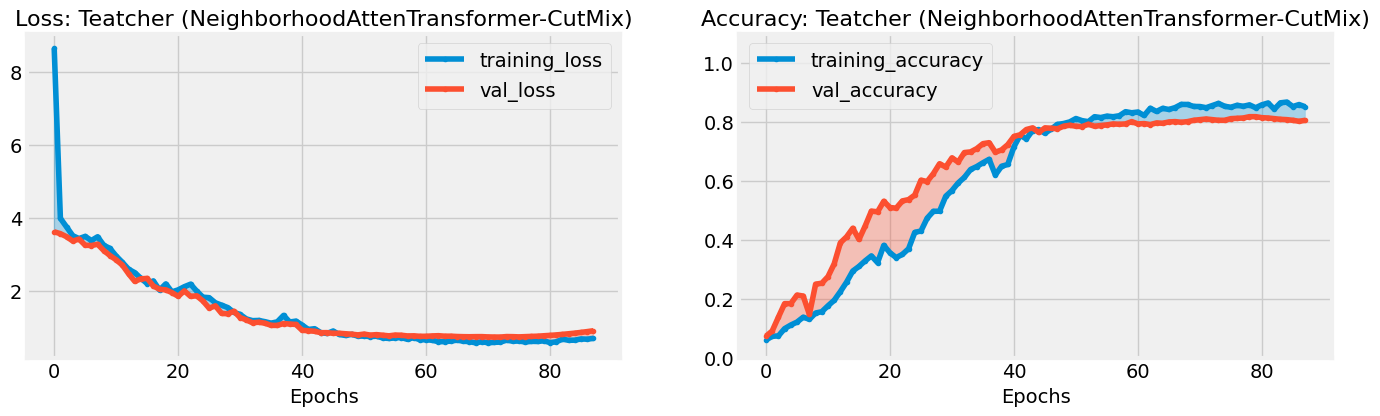

In [ ]:
plot_training_curves(history, 'Teatcher (NeighborhoodAttenTransformer-CutMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(cutmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 46s 246ms/step - accuracy: 0.0790 - top5-acc: 0.2947 - Brier score: 2.8128 - auc: 0.6371 - student_loss: 4.0820 - distillation_loss: 3.1311 - val_accuracy: 0.1989 - val_top5-acc: 0.5039 - val_Brier score: 0.3848 - val_auc: 0.7895 - val_student_loss: 2.9956 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 27s 227ms/step - accuracy: 0.1287 - top5-acc: 0.4262 - Brier score: 1.3075 - auc: 0.7108 - student_loss: 3.2740 - distillation_loss: 2.0441 - val_accuracy: 0.2469 - val_top5-acc: 0.6000 - val_Brier score: 0.5872 - val_auc: 0.8205 - val_student_loss: 2.7535 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 27s 219ms/step - accuracy: 0.1870 - top5-acc: 0.5004 - Brier score: 1.4973 - auc: 0.7310 - student_loss: 3.0734 - distillation_loss: 1.8678 - val_accuracy: 0.3251 - val_top5-acc: 0.6872 - val_Brier score: 0.8517 - val_auc: 0.8415 - val_student_loss: 2.9047 - lr: 0.0010
Epoch 4/100
112/112 [====

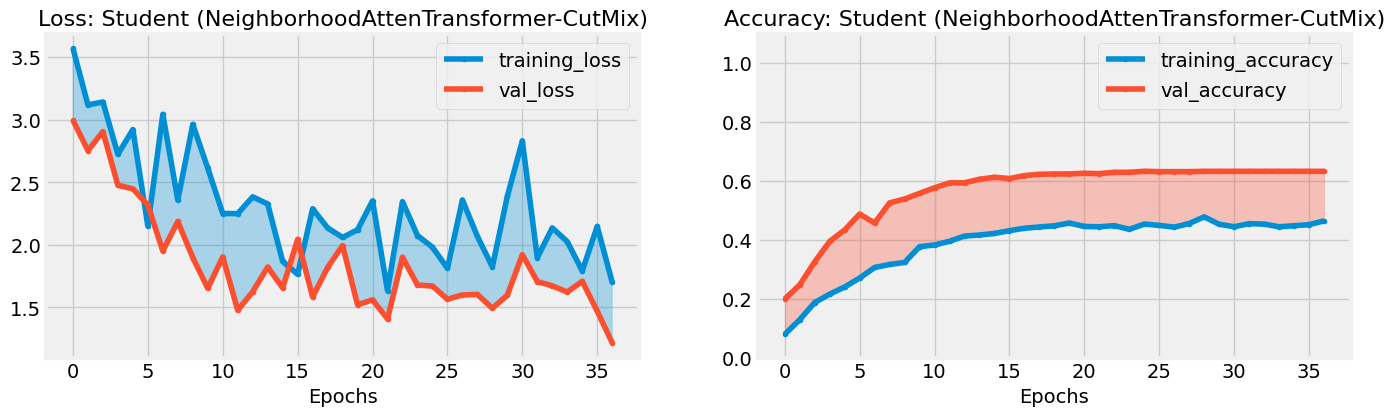

In [ ]:
plot_training_curves(history, 'Student (NeighborhoodAttenTransformer-CutMix)', model_name='student')

### ▶ MixUp







In [ ]:
history = run_experiment(mixup_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 60s 377ms/step - loss: 7.5230 - accuracy: 0.0659 - top5-acc: 0.2210 - Brier score: 19.2009 - auc: 0.5653 - val_loss: 3.6884 - val_accuracy: 0.0704 - val_top5-acc: 0.2112 - val_Brier score: 0.4629 - val_auc: 0.5967 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 42s 358ms/step - loss: 3.9213 - accuracy: 0.0678 - top5-acc: 0.2143 - Brier score: 2.1195 - auc: 0.5595 - val_loss: 3.5872 - val_accuracy: 0.0994 - val_top5-acc: 0.2402 - val_Brier score: 0.3084 - val_auc: 0.5980 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 42s 358ms/step - loss: 3.6442 - accuracy: 0.0971 - top5-acc: 0.2526 - Brier score: 2.5625 - auc: 0.5803 - val_loss: 3.4417 - val_accuracy: 0.1229 - val_top5-acc: 0.2983 - val_Brier score: 0.5996 - val_auc: 0.6588 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 42s 358ms/step - loss: 3.5285 - accuracy: 0.1102 - top5-acc: 0.2746 - Brier score: 2.5115 - auc: 0.59

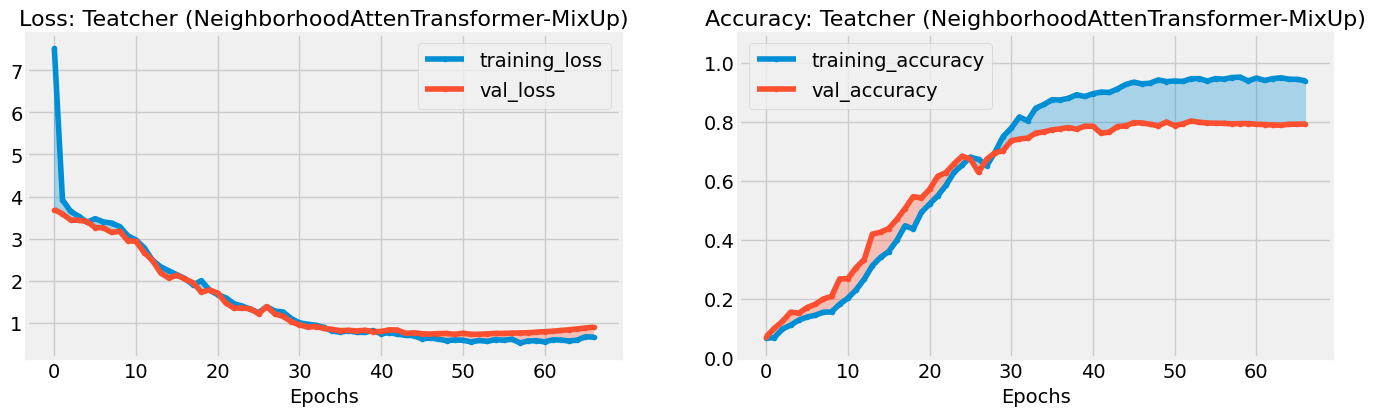

In [ ]:
plot_training_curves(history, 'Teatcher (NeighborhoodAttenTransformer-MixUp)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(mixup_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 46s 247ms/step - accuracy: 0.0924 - top5-acc: 0.3254 - Brier score: 4.2421 - auc: 0.6427 - student_loss: 4.1616 - distillation_loss: 3.3207 - val_accuracy: 0.2168 - val_top5-acc: 0.4927 - val_Brier score: 0.3341 - val_auc: 0.7817 - val_student_loss: 3.3271 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 28s 227ms/step - accuracy: 0.1599 - top5-acc: 0.4479 - Brier score: 2.3409 - auc: 0.7078 - student_loss: 3.2348 - distillation_loss: 2.0096 - val_accuracy: 0.2615 - val_top5-acc: 0.5966 - val_Brier score: 0.7401 - val_auc: 0.8171 - val_student_loss: 2.8891 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 27s 227ms/step - accuracy: 0.2316 - top5-acc: 0.5342 - Brier score: 2.3696 - auc: 0.7255 - student_loss: 2.9549 - distillation_loss: 1.8055 - val_accuracy: 0.3631 - val_top5-acc: 0.6693 - val_Brier score: 0.8226 - val_auc: 0.8367 - val_student_loss: 2.6418 - lr: 0.0010
Epoch 4/100
112/112 [====

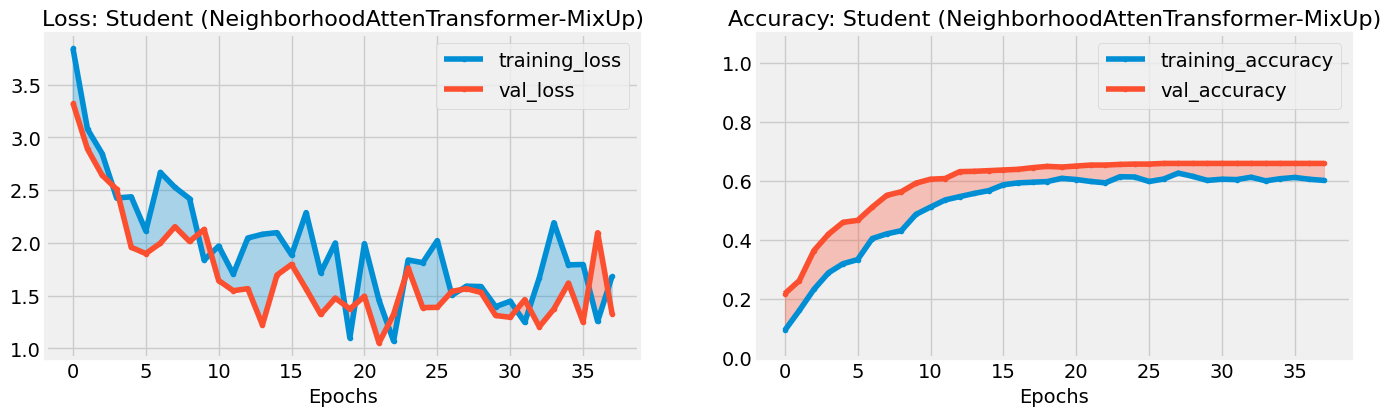

In [ ]:
plot_training_curves(history, 'Student (NeighborhoodAttenTransformer-MixUp)', model_name='student')

### ▶ AugPip







In [ ]:
history = run_experiment(augpip_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
112/112 [==============================] - 96s 700ms/step - loss: 7.9434 - accuracy: 0.0399 - top5-acc: 0.1803 - Brier score: 19.0574 - auc: 0.5376 - val_loss: 3.8260 - val_accuracy: 0.0749 - val_top5-acc: 0.2223 - val_Brier score: 0.6287 - val_auc: 0.5879 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 82s 715ms/step - loss: 4.0261 - accuracy: 0.0483 - top5-acc: 0.1758 - Brier score: 1.0706 - auc: 0.5338 - val_loss: 3.6640 - val_accuracy: 0.1039 - val_top5-acc: 0.2235 - val_Brier score: 0.1232 - val_auc: 0.5472 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 83s 721ms/step - loss: 3.9127 - accuracy: 0.0514 - top5-acc: 0.1775 - Brier score: 0.7392 - auc: 0.5364 - val_loss: 3.6120 - val_accuracy: 0.1140 - val_top5-acc: 0.2838 - val_Brier score: 0.4357 - val_auc: 0.5906 - lr: 0.0010
Epoch 4/100
112/112 [==============================] - 83s 718ms/step - loss: 3.8612 - accuracy: 0.0561 - top5-acc: 0.1881 - Brier score: 0.9463 - auc: 0.54

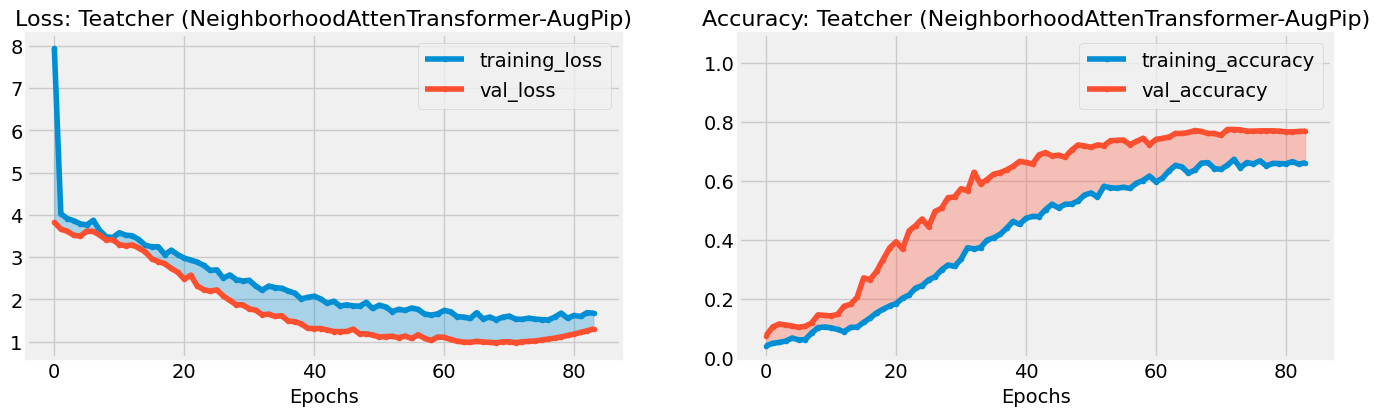

In [ ]:
plot_training_curves(history, 'Teatcher (NeighborhoodAttenTransformer-AugPip)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(augpip_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
112/112 [==============================] - 94s 664ms/step - accuracy: 0.0664 - top5-acc: 0.2417 - Brier score: 2.8572 - auc: 0.6097 - student_loss: 4.1285 - distillation_loss: 2.2170 - val_accuracy: 0.1374 - val_top5-acc: 0.4168 - val_Brier score: 0.1350 - val_auc: 0.7609 - val_student_loss: 3.4459 - lr: 0.0010
Epoch 2/100
112/112 [==============================] - 81s 703ms/step - accuracy: 0.0999 - top5-acc: 0.3494 - Brier score: 0.7528 - auc: 0.6677 - student_loss: 3.4528 - distillation_loss: 1.0831 - val_accuracy: 0.1855 - val_top5-acc: 0.5151 - val_Brier score: 0.2942 - val_auc: 0.7947 - val_student_loss: 3.2346 - lr: 0.0010
Epoch 3/100
112/112 [==============================] - 80s 696ms/step - accuracy: 0.1273 - top5-acc: 0.4005 - Brier score: 0.7570 - auc: 0.6836 - student_loss: 3.3628 - distillation_loss: 1.0111 - val_accuracy: 0.2257 - val_top5-acc: 0.5665 - val_Brier score: 0.3991 - val_auc: 0.8080 - val_student_loss: 3.2195 - lr: 0.0010
Epoch 4/100
112/112 [====

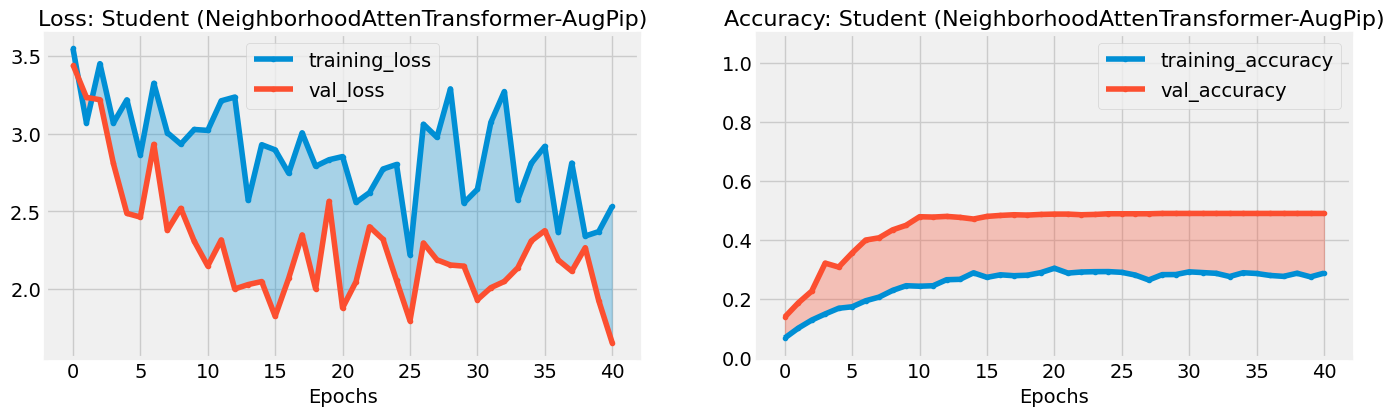

In [ ]:
plot_training_curves(history, 'Student (NeighborhoodAttenTransformer-AugPip)', model_name='student')



---

##⏰ Flush

In [ ]:
del history
del transformer_teacher
del transformer_student



---

